Helper Functions

## Precipitation

### Historical

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import calendar


# --- Configuration (from your input) ---
model_configurations = [
    {
        "name": "CNRM-ESM2-1",
        "variant_member": "r1i1p1f2",
        "grid_label_obs": "gr",
        "grid_label_raw_downscaled": "gr",
        "obs_base_path": "/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/RO_NEX-GDDP-CMIP6/CNRM-ESM2-1",
        "raw_base_path": "/data/keeling/a/cristi/a/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1",
        "downscaled_base_path": "/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/CNRM-ESM2-1",
    },
    {
        "name": "EC-Earth3-Veg-LR",
        "variant_member": "r1i1p1f1",
        "grid_label_obs": "gr",
        "grid_label_raw_downscaled": "gr",
        "obs_base_path": "/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/RO_NEX-GDDP-CMIP6/EC-Earth3-Veg-LR",
        "raw_base_path": "/data/keeling/a/cristi/a/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/EC-Earth3-Veg-LR",
        "downscaled_base_path": "/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/EC-Earth3-Veg-LR",
    },
    {
        "name": "IPSL-CM6A-LR",
        "variant_member": "r1i1p1f1",
        "grid_label_obs": "gr",
        "grid_label_raw_downscaled": "gr",
        "obs_base_path": "/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/RO_NEX-GDDP-CMIP6/IPSL-CM6A-LR",
        "raw_base_path": "/data/keeling/a/cristi/a/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/IPSL-CM6A-LR",
        "downscaled_base_path": "/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/IPSL-CM6A-LR",
    },
    {
        "name": "MIROC6",
        "variant_member": "r1i1p1f1",
        "grid_label_obs": "gn",
        "grid_label_raw_downscaled": "gr", 
        "obs_base_path": "/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/RO_NEX-GDDP-CMIP6/MIROC6",
        "raw_base_path": "/data/keeling/a/cristi/a/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/MIROC6",
        "downscaled_base_path": "/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MIROC6",
    },
    {
        "name": "MPI-ESM1-2-HR",
        "variant_member": "r1i1p1f1",
        "grid_label_obs": "gn",
        "grid_label_raw_downscaled": "gr", 
        "obs_base_path": "/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/RO_NEX-GDDP-CMIP6/MPI-ESM1-2-HR",
        "raw_base_path": "/data/keeling/a/cristi/a/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/MPI-ESM1-2-HR",
        "downscaled_base_path": "/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MPI-ESM1-2-HR",
    },
    {
        "name": "MPI-ESM1-2-LR",
        "variant_member": "r1i1p1f1",
        "grid_label_obs": "gn",
        "grid_label_raw_downscaled": "gr",
        "obs_base_path": "/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/RO_NEX-GDDP-CMIP6/MPI-ESM1-2-LR",
        "raw_base_path": "/data/keeling/a/cristi/a/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/MPI-ESM1-2-LR",
        "downscaled_base_path": "/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MPI-ESM1-2-LR",
    }
]

# Month names for better labeling
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
# Desired order for daprets in legend and plots
desired_hue_order = ['CMIP6 Raw', 'NEX-GDDP', 'ViT', 'GAN']
# Historical years range
historical_years = range(1950, 2015) # Defines years 1950-2014

validation_start_year = 1981
validation_end_year = 2010

In [2]:
nexgddp_hist_files = sorted(glob.glob(os.path.join("/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/RO_NEX-GDDP-CMIP6/CNRM-ESM2-1/historical/r1i1p1f2/pr/", '*_rou.nc')))
nexgddp = xr.open_mfdataset(nexgddp_hist_files, combine='by_coords', chunks={'time': -1}, engine='netcdf4')
nexgddp['pr'] = nexgddp['pr'] * 86400
nexgddp_monthly = nexgddp.resample(time='MS').sum()['pr'].sel(
                time=slice(f"{validation_start_year}-01-01", f"{validation_end_year}-12-31")
            ).load()


In [3]:
def process_model_data(config, years_range, period, validation_start_year, validation_end_year):
    model_name = config["name"]
    variant_member = config["variant_member"]
    grid_label_obs = config["grid_label_obs"]
    grid_label_raw_downscaled = config["grid_label_raw_downscaled"]

    # Determine year strings for file names (e.g., "1950", "2014")
    start_year_str = str(years_range[0])
    end_year_str = str(years_range[-1])
    print(start_year_str)
    print(end_year_str)

    # Construct the directory path for observational data
    var_dir = os.path.join(
        config["obs_base_path"],
        period,
        variant_member,
        "pr"
    )

    # Use glob to list all files ending with '_rou.nc' in the directory
    nexgddp_hist_files = sorted(glob.glob(os.path.join(var_dir, '*_rou.nc')))
    cmip6_hist_file = f'{config["raw_base_path"]}/{period}/{variant_member}/pr/pr_day_{model_name}_{period}_{variant_member}_{grid_label_raw_downscaled}_{start_year_str}_{end_year_str}_rou.zarr'
    vit_hist_file = f'{config["downscaled_base_path"]}/{period}/{variant_member}/pr/pr_day_vit_{model_name}_{period}_{variant_member}_{grid_label_raw_downscaled}_{start_year_str}_{end_year_str}_rou.nc'
    gan_hist_file = f'{config["downscaled_base_path"]}/{period}/{variant_member}/pr/pr_day_gan_{model_name}_{period}_{variant_member}_{grid_label_raw_downscaled}_{start_year_str}_{end_year_str}_rou.nc'

    print(f"--- Processing model: {model_name} ---")
    
    datasets_to_return = {}

    try:
        # NEX-GDDP (Observational reference for downscaling)
        print(f"Loading NEX-GDDP for {model_name}...")
        try:
            nexgddp = xr.open_mfdataset(nexgddp_hist_files, combine='by_coords', chunks={'time': -1}, engine='netcdf4')
            nexgddp['pr'] =  nexgddp['pr'] * 86400
            nexgddp_monthly = nexgddp.resample(time='MS').sum()['pr'].sel(
                time=slice(f"{validation_start_year}-01-01", f"{validation_end_year}-12-31")
            ).load()
            datasets_to_return['NEX-GDDP'] = nexgddp_monthly
        except Exception as e:
            print(f"ERROR: Could not load or process NEX-GDDP for {model_name}. This model will be skipped. Details: {e}")
            return None, model_name

        # Create mask and define target grid from NEX-GDDP
        mask_nexgddp_na = nexgddp_monthly.isnull()
        target_lat = nexgddp_monthly.lat
        target_lon = nexgddp_monthly.lon

        # CMIP6 Raw
        print(f"Loading CMIP6 Raw for {model_name}...")
        try:
            cmip6 = xr.open_zarr(cmip6_hist_file, consolidated=True)
            cmip6['pr'] = cmip6['pr'] * 86400
            cmip6_monthly_resampled = cmip6.resample(time='MS').sum()
            cmip6_high_da = cmip6_monthly_resampled['pr'].interp(
                lat=target_lat, lon=target_lon, method="nearest", kwargs={"fill_value": "extrapolate"}
            ).sel(time=slice(f"{validation_start_year}-01-01", f"{validation_end_year}-12-31"))
            cmip6_high = cmip6_high_da.where(~mask_nexgddp_na, np.nan).load()
            datasets_to_return['CMIP6 Raw'] = cmip6_high
        except Exception as e:
            print(f"Warning: Could not load or process CMIP6 Raw for {model_name}. Details: {e}")

        # ViT Downscaled
        print(f"Loading ViT downscaled for {model_name}...")
        try:
            vit = xr.open_dataset(vit_hist_file, engine='netcdf4')
            vit_monthly_da = vit.resample(time='MS').sum()
            vit_monthly = vit_monthly_da['pr_downscaled'].sel(
                time=slice(f"{validation_start_year}-01-01", f"{validation_end_year}-12-31")
            ).where(~mask_nexgddp_na, np.nan).load()
            datasets_to_return['ViT'] = vit_monthly
        except Exception as e:
            print(f"Warning: Could not load or process ViT for {model_name}. Details: {e}")
        
        # GAN Downscaled
        print(f"Loading GAN downscaled for {model_name}...")
        try:
            gan = xr.open_dataset(gan_hist_file, engine='netcdf4')
            gan_monthly_da = gan.resample(time='MS').sum()
            gan_monthly = gan_monthly_da['pr_downscaled'].sel(
                time=slice(f"{validation_start_year}-01-01", f"{validation_end_year}-12-31")
            ).where(~mask_nexgddp_na, np.nan).load()
            datasets_to_return['GAN'] = gan_monthly
        except Exception as e:
            print(f"Warning: Could not load or process GAN for {model_name}. Details: {e}")

        # Final check
        if not datasets_to_return or 'NEX-GDDP' not in datasets_to_return:
            print(f"Critical data missing for model {model_name}, cannot proceed with this model.")
            return None, model_name

        return datasets_to_return, model_name

    except Exception as e:
        print(f"CRITICAL ERROR processing model {model_name}: {e}")
        return None, model_name

In [4]:
# --- Main data processing and aggregation loop ---
all_plot_data_list = []
valid_model_configs_processed = [] # Store configs for models that were successfully processed

period = 'historical'

print("Starting data processing for all configured models...")
for config in model_configurations:
    model_data_dict, model_name_processed = process_model_data(config, historical_years,period, validation_start_year, validation_end_year)
    
    if model_data_dict and model_name_processed:
        valid_model_configs_processed.append(config) # Add config for successfully processed model
        
        for ds_name, ds_xarray in model_data_dict.items():
            # Data is already loaded into memory by process_model_data function
            for month_int, group_data in ds_xarray.groupby('time.month'):
                month_label = month_names[month_int - 1]
                
                # Flatten spatial and temporal (within month) dimensions, then remove NaNs
                values = group_data.data.flatten() 
                values = values[~np.isnan(values)]
                
                for val in values:
                    all_plot_data_list.append({
                        'Model_Name': model_name_processed,
                        'Month': month_label,
                        'Month_Num': month_int, # For sorting
                        'Dataset': ds_name,
                        'Precipitation (mm)': val
                    })
    else:
        print(f"Failed to retrieve or process data for model: {config.get('name', 'Unknown Model')}. It will be excluded from the plot.")


df_plot_all = pd.DataFrame(all_plot_data_list)


# Prepare DataFrame for plotting: set 'Month' as categorical for correct order
df_plot_all['Month'] = pd.Categorical(df_plot_all['Month'], categories=month_names, ordered=True)
# Sort values for consistent processing, though seaborn handles categorical order
df_plot_all = df_plot_all.sort_values(by=['Model_Name', 'Month_Num', 'Dataset'])

print("Data aggregation complete. Preparing to plot...")


Starting data processing for all configured models...
1950
2014
--- Processing model: CNRM-ESM2-1 ---
Loading NEX-GDDP for CNRM-ESM2-1...
Loading CMIP6 Raw for CNRM-ESM2-1...
Loading ViT downscaled for CNRM-ESM2-1...
Loading GAN downscaled for CNRM-ESM2-1...
1950
2014
--- Processing model: EC-Earth3-Veg-LR ---
Loading NEX-GDDP for EC-Earth3-Veg-LR...
Loading CMIP6 Raw for EC-Earth3-Veg-LR...
Loading ViT downscaled for EC-Earth3-Veg-LR...
Loading GAN downscaled for EC-Earth3-Veg-LR...
1950
2014
--- Processing model: IPSL-CM6A-LR ---
Loading NEX-GDDP for IPSL-CM6A-LR...
Loading CMIP6 Raw for IPSL-CM6A-LR...
Loading ViT downscaled for IPSL-CM6A-LR...
Loading GAN downscaled for IPSL-CM6A-LR...
1950
2014
--- Processing model: MIROC6 ---
Loading NEX-GDDP for MIROC6...
Loading CMIP6 Raw for MIROC6...
Loading ViT downscaled for MIROC6...
Loading GAN downscaled for MIROC6...
1950
2014
--- Processing model: MPI-ESM1-2-HR ---
Loading NEX-GDDP for MPI-ESM1-2-HR...
Loading CMIP6 Raw for MPI-ESM1-2-

#### Box-plots

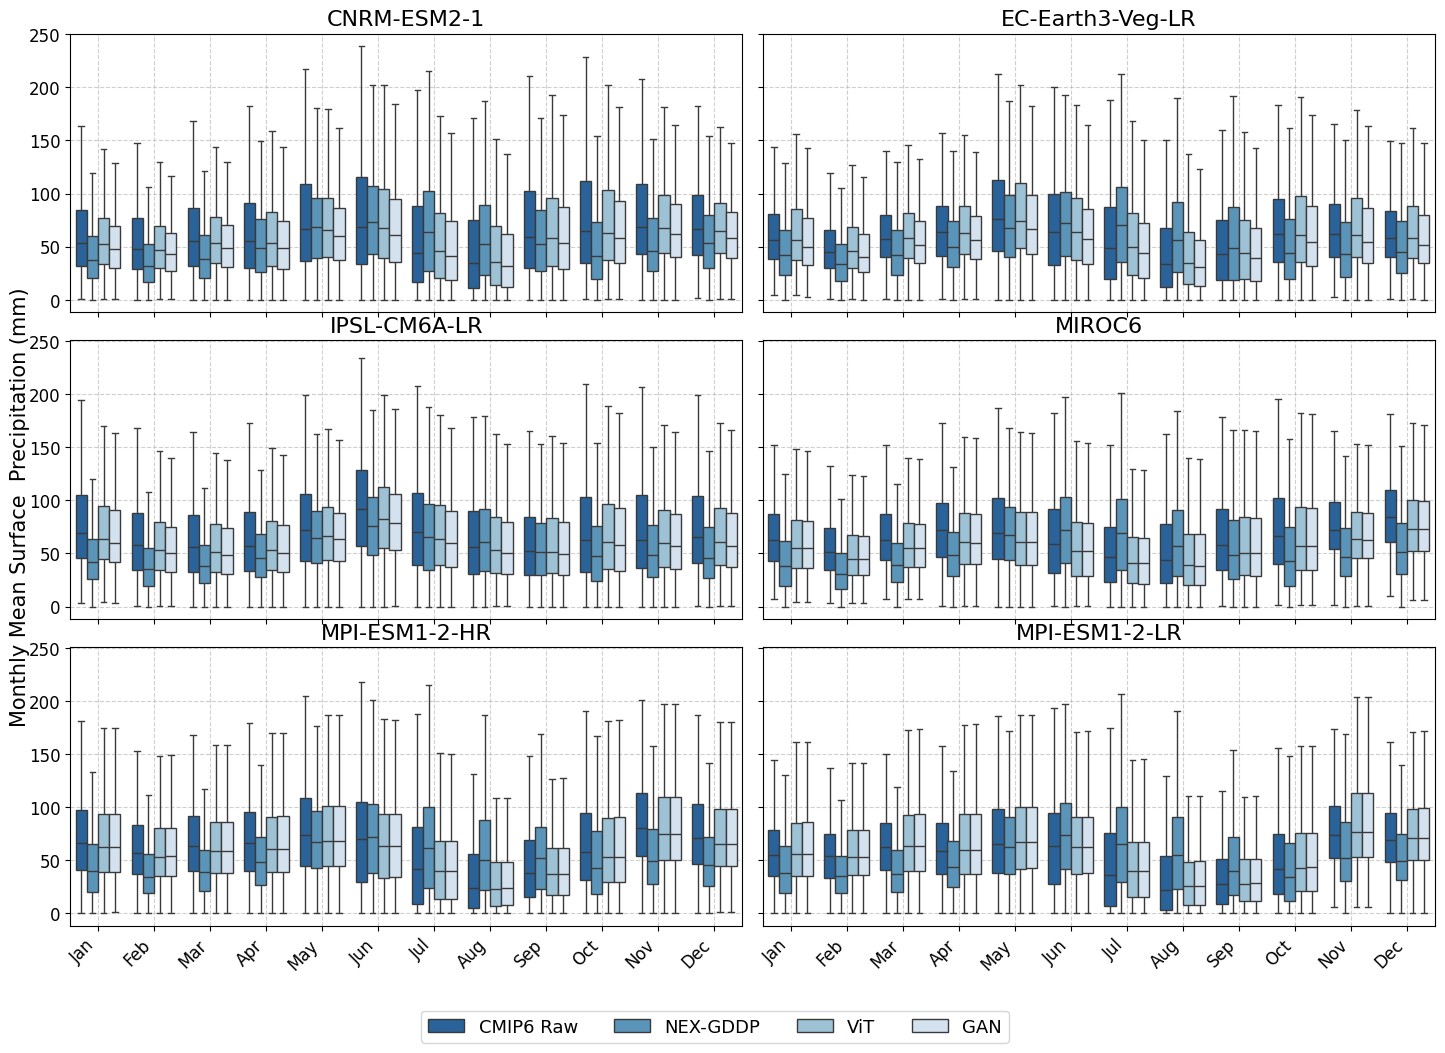

In [5]:

# --- Panel Plotting ---
num_models_to_plot = len(valid_model_configs_processed)

# Determine grid size for subplots (e.g., 2 columns)
ncols = 2 
nrows = (num_models_to_plot + ncols - 1) // ncols # Ceiling division to get enough rows

fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(7.5 * ncols, 3.5 * nrows), # Adjust figsize as needed
    sharey=True, # All subplots share the same y-axis scale
    sharex=True  # All subplots share the same x-axis (months)
)
axes = np.array(axes).flatten() # Flatten axes array for easy iteration

handles, labels = None, None # To store legend items from the first plot

for i, config in enumerate(valid_model_configs_processed):
    ax = axes[i]
    current_model_name = config["name"]
    
    # Filter data for the current model
    df_model = df_plot_all[df_plot_all['Model_Name'] == current_model_name]

    sns.boxplot(
        x='Month', 
        y='Precipitation (mm)', 
        hue='Dataset', 
        data=df_model,
        hue_order=desired_hue_order, # Ensure consistent dataset order
        palette='Blues_r', # Color palette
        showfliers=False, # Do not show outliers to keep plots cleaner
        ax=ax,
        legend= (i == 0) # Generate legend items only for the first plot
    )
    
    ax.set_title(current_model_name, fontsize=16)
    ax.set_xlabel('') # Individual x-labels turned off for shared axis
    ax.set_ylabel('') # Individual y-labels turned off for shared axis

    # --- CORRECTED TICK PARAMETERS ---
    # Apply styling to x-axis tick labels: rotation and size
    ax.tick_params(axis='x', labelrotation=45, labelsize=12)
    # Set horizontal alignment for the rotated x-tick labels
    plt.setp(ax.get_xticklabels(), ha='right') 
    
    # Apply styling to y-axis tick labels: size
    ax.tick_params(axis='y', labelsize=12)
    # --- END CORRECTION ---
    
    ax.grid(True, linestyle='--', alpha=0.6)

    # Capture legend handles and labels from the first plot that has a legend
    if i == 0 and ax.get_legend() is not None:
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove() # Remove legend from the subplot itself


# Set common (super) labels for the entire figure
fig.supxlabel('') 
fig.supylabel('Monthly Mean Surface  Precipitation (mm)', fontsize=15, x=0.03)

# Add a single, shared legend to the figure

fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02 if nrows >=3 else -0.005), ncol=len(desired_hue_order), fontsize=13)
plt.subplots_adjust(left=0.07, right=0.98, top=0.95,  bottom=0.1,  hspace=0.1,wspace=0.03)


plt.show()


#### Maps

In [6]:
all_annual_mean_maps = {} # Structure: {model_name: {dataset_name: xr.DataArray}}
valid_model_configs_for_maps = []
global_min_temp = np.inf
global_max_temp = -np.inf

print("Starting data processing for multi-annual mean maps...")
for config in model_configurations:
    model_monthly_data, model_name =  process_model_data(config, historical_years,period, validation_start_year, validation_end_year)
    
    if model_monthly_data and 'NEX-GDDP' in model_monthly_data: # Ensure base data exists
        valid_model_configs_for_maps.append(config)
        all_annual_mean_maps[model_name] = {}
        
        for ds_name, ds_xarray_monthly in model_monthly_data.items():
            print(f"Calculating annual mean for {model_name} - {ds_name}")
            try:
                # Calculate mean over the 'time' dimension (all months, all years)
                # Step 1: Compute annual sums (per year)
                annual_sums = ds_xarray_monthly.resample(time='1YE').sum(dim='time', skipna=True)

                    # Step 2: Compute multi-annual mean of the annual sums
                annual_mean_map = annual_sums.mean(dim='time', skipna=True).load()
                all_annual_mean_maps[model_name][ds_name] = annual_mean_map
                
                # Update global min/max for color scale
                current_min = 300
                current_max = 1500
                if not np.isnan(current_min):
                    global_min_temp = min(global_min_temp, current_min)
                if not np.isnan(current_max):
                    global_max_temp = max(global_max_temp, current_max)
            except Exception as e:
                print(f"Error calculating annual mean for {model_name} - {ds_name}: {e}")
                all_annual_mean_maps[model_name][ds_name] = None # Mark as failed
    else:
        print(f"Skipping maps for model: {config.get('name', 'Unknown Model')} due to missing data.")

if not valid_model_configs_for_maps:
    print("No models have sufficient data for plotting annual mean maps. Exiting.")
    # exit() # Or handle
elif global_min_temp == np.inf or global_max_temp == -np.inf:
    print("Could not determine a valid global precipitation range for color scale. Exiting map plotting.")
    # exit() # Or handle

print(f"Global precipitation range for maps: {global_min_temp:.2f}K to {global_max_temp:.2f}K")
print("Data for maps prepared. Now plotting...")

Starting data processing for multi-annual mean maps...
1950
2014
--- Processing model: CNRM-ESM2-1 ---
Loading NEX-GDDP for CNRM-ESM2-1...
Loading CMIP6 Raw for CNRM-ESM2-1...
Loading ViT downscaled for CNRM-ESM2-1...
Loading GAN downscaled for CNRM-ESM2-1...
Calculating annual mean for CNRM-ESM2-1 - NEX-GDDP
Calculating annual mean for CNRM-ESM2-1 - CMIP6 Raw
Calculating annual mean for CNRM-ESM2-1 - ViT
Calculating annual mean for CNRM-ESM2-1 - GAN
1950
2014
--- Processing model: EC-Earth3-Veg-LR ---
Loading NEX-GDDP for EC-Earth3-Veg-LR...
Loading CMIP6 Raw for EC-Earth3-Veg-LR...
Loading ViT downscaled for EC-Earth3-Veg-LR...
Loading GAN downscaled for EC-Earth3-Veg-LR...
Calculating annual mean for EC-Earth3-Veg-LR - NEX-GDDP
Calculating annual mean for EC-Earth3-Veg-LR - CMIP6 Raw
Calculating annual mean for EC-Earth3-Veg-LR - ViT
Calculating annual mean for EC-Earth3-Veg-LR - GAN
1950
2014
--- Processing model: IPSL-CM6A-LR ---
Loading NEX-GDDP for IPSL-CM6A-LR...
Loading CMIP6 

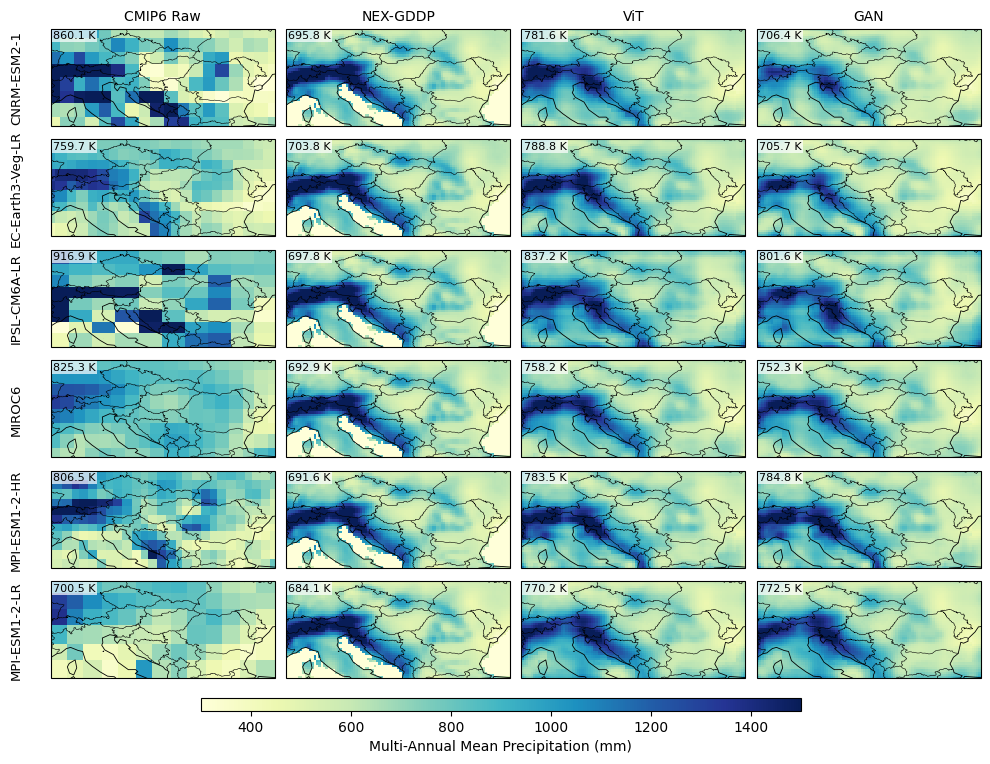

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Panel Plotting for Maps ---
dataset_order_for_maps = ['CMIP6 Raw', 'NEX-GDDP', 'ViT', 'GAN']
num_models_to_plot = len(valid_model_configs_for_maps)
num_datasets_per_model = len(dataset_order_for_maps)  # Should be 4

if num_models_to_plot == 0:
    print("No models available for map plotting.")
else:
    projection = ccrs.PlateCarree()

    fig_maps, axes_maps = plt.subplots(
        nrows=num_models_to_plot,
        ncols=num_datasets_per_model,
        figsize=(12, 8.5),
        subplot_kw={'projection': projection},
        squeeze=False
    )

    plot_mappable = None

    for i, config in enumerate(valid_model_configs_for_maps):
        model_name = config["name"]
        for j, ds_name in enumerate(dataset_order_for_maps):
            ax = axes_maps[i, j]

            current_map = all_annual_mean_maps[model_name][ds_name]

            plot_mappable = current_map.plot(
                ax=ax,
                transform=ccrs.PlateCarree(),
                vmin=global_min_temp,
                vmax=global_max_temp,
                cmap='YlGnBu',
                add_colorbar=False
            )

            # Add mean areal value in top-left corner
            mean_val = float(current_map.mean().values)
            ax.text(
                0.01, 0.98,
                f"{mean_val:.1f} K",
                transform=ax.transAxes,
                fontsize=8,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=dict(facecolor='white', edgecolor='none', pad=1, alpha=0.7)
            )

            # Set title on top row
            ax.set_title(f"{ds_name}" if i == 0 else "", fontsize=10)

            # Coastlines and borders
            ax.coastlines(resolution='110m', linewidth=0.6)
            ax.add_feature(cfeature.BORDERS, linewidth=0.4)

            # Y-axis labels on first column only
            ax.set_ylabel(model_name if j == 0 else "", fontsize=9.5, rotation=90, labelpad=20)

            # X-axis labels on bottom row only
            if i == num_models_to_plot - 1:
                ax.tick_params(axis='x', labelsize=10)
                ax.set_xlabel('')
            else:
                ax.set_xticks([])
                ax.set_xticklabels([])
                ax.set_xlabel('')

            # Hide y-axis ticks and label font size
            ax.set_yticks([])
            ax.tick_params(axis='y', labelsize=10)

    if plot_mappable is not None:
        # --- Add a centered horizontal colorbar ---
        cbar_ax = fig_maps.add_axes([
            0.25,   # left
            0.07,   # bottom
            0.5,    # width
            0.015   # height
        ])

        cb = fig_maps.colorbar(
            plot_mappable,
            cax=cbar_ax,
            orientation='horizontal'
        )

        cb.ax.tick_params(labelsize=10)
        cb.set_label('Multi-Annual Mean Precipitation (mm)', size=10)

        # Adjust layout to make room for colorbar
        fig_maps.subplots_adjust(bottom=0.1, wspace=0.05, hspace=0.0)

    plt.show()


### SSP 126

In [8]:
# --- Main data processing and aggregation loop ---
all_plot_data_list = []
valid_model_configs_processed = [] # Store configs for models that were successfully processed
historical_years = range(2015, 2101) # Defines years 1950-2014
validation_start_year = 2071
validation_end_year = 2100
period = 'ssp126'

print("Starting data processing for all configured models...")
for config in model_configurations:
    model_data_dict, model_name_processed = process_model_data(config, historical_years,period, validation_start_year, validation_end_year)
    
    if model_data_dict and model_name_processed:
        valid_model_configs_processed.append(config) # Add config for successfully processed model
        
        for ds_name, ds_xarray in model_data_dict.items():
            # Data is already loaded into memory by process_model_data function
            for month_int, group_data in ds_xarray.groupby('time.month'):
                month_label = month_names[month_int - 1]
                
                # Flatten spatial and temporal (within month) dimensions, then remove NaNs
                values = group_data.data.flatten() 
                values = values[~np.isnan(values)]
                
                for val in values:
                    all_plot_data_list.append({
                        'Model_Name': model_name_processed,
                        'Month': month_label,
                        'Month_Num': month_int, # For sorting
                        'Dataset': ds_name,
                        'Precipitation (mm)': val
                    })
    else:
        print(f"Failed to retrieve or process data for model: {config.get('name', 'Unknown Model')}. It will be excluded from the plot.")


df_plot_all = pd.DataFrame(all_plot_data_list)


# Prepare DataFrame for plotting: set 'Month' as categorical for correct order
df_plot_all['Month'] = pd.Categorical(df_plot_all['Month'], categories=month_names, ordered=True)
# Sort values for consistent processing, though seaborn handles categorical order
df_plot_all = df_plot_all.sort_values(by=['Model_Name', 'Month_Num', 'Dataset'])

print("Data aggregation complete. Preparing to plot...")


Starting data processing for all configured models...
2015
2100
--- Processing model: CNRM-ESM2-1 ---
Loading NEX-GDDP for CNRM-ESM2-1...
Loading CMIP6 Raw for CNRM-ESM2-1...
Loading ViT downscaled for CNRM-ESM2-1...
Loading GAN downscaled for CNRM-ESM2-1...
2015
2100
--- Processing model: EC-Earth3-Veg-LR ---
Loading NEX-GDDP for EC-Earth3-Veg-LR...
Loading CMIP6 Raw for EC-Earth3-Veg-LR...
Loading ViT downscaled for EC-Earth3-Veg-LR...
Loading GAN downscaled for EC-Earth3-Veg-LR...
2015
2100
--- Processing model: IPSL-CM6A-LR ---
Loading NEX-GDDP for IPSL-CM6A-LR...
Loading CMIP6 Raw for IPSL-CM6A-LR...
Loading ViT downscaled for IPSL-CM6A-LR...
Loading GAN downscaled for IPSL-CM6A-LR...
2015
2100
--- Processing model: MIROC6 ---
Loading NEX-GDDP for MIROC6...
Loading CMIP6 Raw for MIROC6...
Loading ViT downscaled for MIROC6...
Loading GAN downscaled for MIROC6...
2015
2100
--- Processing model: MPI-ESM1-2-HR ---
Loading NEX-GDDP for MPI-ESM1-2-HR...
Loading CMIP6 Raw for MPI-ESM1-2-

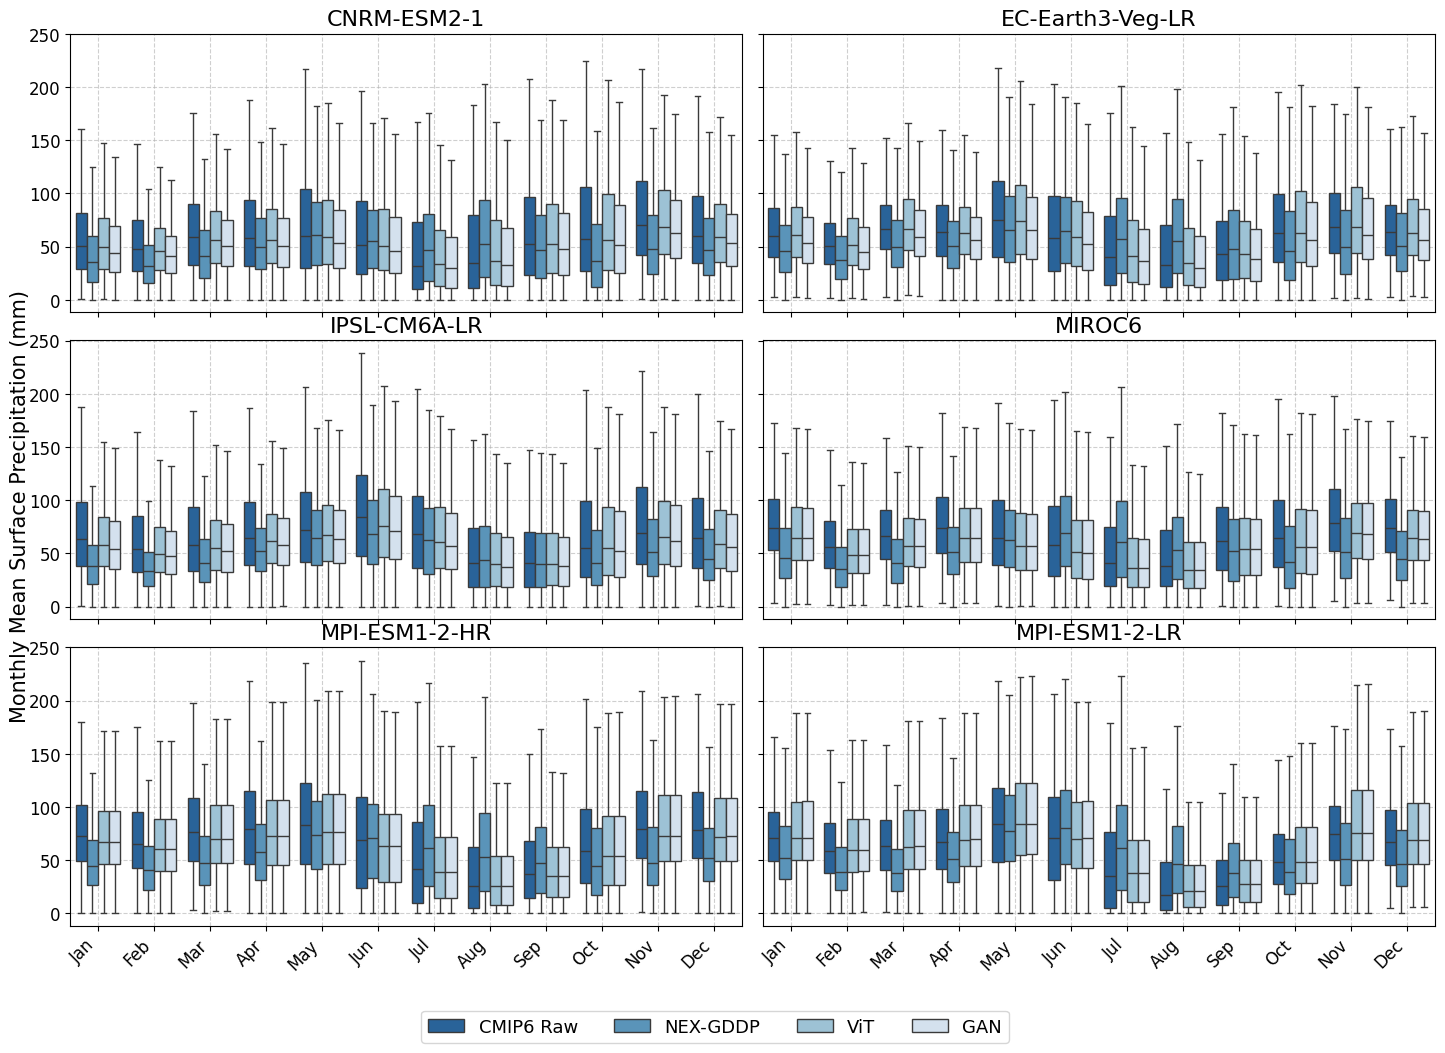

In [9]:

# --- Panel Plotting ---
num_models_to_plot = len(valid_model_configs_processed)

# Determine grid size for subplots (e.g., 2 columns)
ncols = 2 
nrows = (num_models_to_plot + ncols - 1) // ncols # Ceiling division to get enough rows

fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(7.5 * ncols, 3.5 * nrows), # Adjust figsize as needed
    sharey=True, # All subplots share the same y-axis scale
    sharex=True  # All subplots share the same x-axis (months)
)
axes = np.array(axes).flatten() # Flatten axes array for easy iteration

handles, labels = None, None # To store legend items from the first plot

for i, config in enumerate(valid_model_configs_processed):
    ax = axes[i]
    current_model_name = config["name"]
    
    # Filter data for the current model
    df_model = df_plot_all[df_plot_all['Model_Name'] == current_model_name]

    sns.boxplot(
        x='Month', 
        y='Precipitation (mm)', 
        hue='Dataset', 
        data=df_model,
        hue_order=desired_hue_order, # Ensure consistent dataset order
        palette='Blues_r', # Color palette
        showfliers=False, # Do not show outliers to keep plots cleaner
        ax=ax,
        legend= (i == 0) # Generate legend items only for the first plot
    )
    
    ax.set_title(current_model_name, fontsize=16)
    ax.set_xlabel('') # Individual x-labels turned off for shared axis
    ax.set_ylabel('') # Individual y-labels turned off for shared axis

    # --- CORRECTED TICK PARAMETERS ---
    # Apply styling to x-axis tick labels: rotation and size
    ax.tick_params(axis='x', labelrotation=45, labelsize=12)
    # Set horizontal alignment for the rotated x-tick labels
    plt.setp(ax.get_xticklabels(), ha='right') 
    
    # Apply styling to y-axis tick labels: size
    ax.tick_params(axis='y', labelsize=12)
    # --- END CORRECTION ---
    
    ax.grid(True, linestyle='--', alpha=0.6)

    # Capture legend handles and labels from the first plot that has a legend
    if i == 0 and ax.get_legend() is not None:
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove() # Remove legend from the subplot itself


# Set common (super) labels for the entire figure
fig.supxlabel('') 
fig.supylabel('Monthly Mean Surface Precipitation (mm)', fontsize=15, x=0.03)

# Add a single, shared legend to the figure

fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02 if nrows >=3 else -0.005), ncol=len(desired_hue_order), fontsize=13)
plt.subplots_adjust(left=0.07, right=0.98, top=0.95,  bottom=0.1,  hspace=0.1,wspace=0.03)


plt.show()


In [10]:
all_ssp_mean_maps = {} # Structure: {model_name: {dataset_name: xr.DataArray}}
valid_model_configs_for_maps = []
global_min_temp = np.inf
global_max_temp = -np.inf

print("Starting data processing for multi-annual mean maps...")
for config in model_configurations:
    model_monthly_data, model_name =  process_model_data(config, historical_years,period, validation_start_year, validation_end_year)
    
    if model_monthly_data and 'NEX-GDDP' in model_monthly_data: # Ensure base data exists
        valid_model_configs_for_maps.append(config)
        all_ssp_mean_maps[model_name] = {}
        
        for ds_name, ds_xarray_monthly in model_monthly_data.items():
            print(f"Calculating annual mean for {model_name} - {ds_name}")
            try:
                # Calculate mean over the 'time' dimension (all months, all years)
                annual_sums = ds_xarray_monthly.resample(time='1YE').sum(dim='time', skipna=True)

                    # Step 2: Compute multi-annual mean of the annual sums
                annual_mean_map = annual_sums.mean(dim='time', skipna=True).load()
                all_ssp_mean_maps[model_name][ds_name] = annual_mean_map
                
                # Update global min/max for color scale
                current_min = 300
                current_max = 1500
                if not np.isnan(current_min):
                    global_min_temp = min(global_min_temp, current_min)
                if not np.isnan(current_max):
                    global_max_temp = max(global_max_temp, current_max)
            except Exception as e:
                print(f"Error calculating annual mean for {model_name} - {ds_name}: {e}")
                all_ssp_mean_maps[model_name][ds_name] = None # Mark as failed
    else:
        print(f"Skipping maps for model: {config.get('name', 'Unknown Model')} due to missing data.")

if not valid_model_configs_for_maps:
    print("No models have sufficient data for plotting annual mean maps. Exiting.")
    # exit() # Or handle
elif global_min_temp == np.inf or global_max_temp == -np.inf:
    print("Could not determine a valid global precipitation range for color scale. Exiting map plotting.")
    # exit() # Or handle

print(f"Global precipitation range for maps: {global_min_temp:.2f}K to {global_max_temp:.2f}K")
print("Data for maps prepared. Now plotting...")

Starting data processing for multi-annual mean maps...
2015
2100
--- Processing model: CNRM-ESM2-1 ---
Loading NEX-GDDP for CNRM-ESM2-1...
Loading CMIP6 Raw for CNRM-ESM2-1...
Loading ViT downscaled for CNRM-ESM2-1...
Loading GAN downscaled for CNRM-ESM2-1...
Calculating annual mean for CNRM-ESM2-1 - NEX-GDDP
Calculating annual mean for CNRM-ESM2-1 - CMIP6 Raw
Calculating annual mean for CNRM-ESM2-1 - ViT
Calculating annual mean for CNRM-ESM2-1 - GAN
2015
2100
--- Processing model: EC-Earth3-Veg-LR ---
Loading NEX-GDDP for EC-Earth3-Veg-LR...
Loading CMIP6 Raw for EC-Earth3-Veg-LR...
Loading ViT downscaled for EC-Earth3-Veg-LR...
Loading GAN downscaled for EC-Earth3-Veg-LR...
Calculating annual mean for EC-Earth3-Veg-LR - NEX-GDDP
Calculating annual mean for EC-Earth3-Veg-LR - CMIP6 Raw
Calculating annual mean for EC-Earth3-Veg-LR - ViT
Calculating annual mean for EC-Earth3-Veg-LR - GAN
2015
2100
--- Processing model: IPSL-CM6A-LR ---
Loading NEX-GDDP for IPSL-CM6A-LR...
Loading CMIP6 

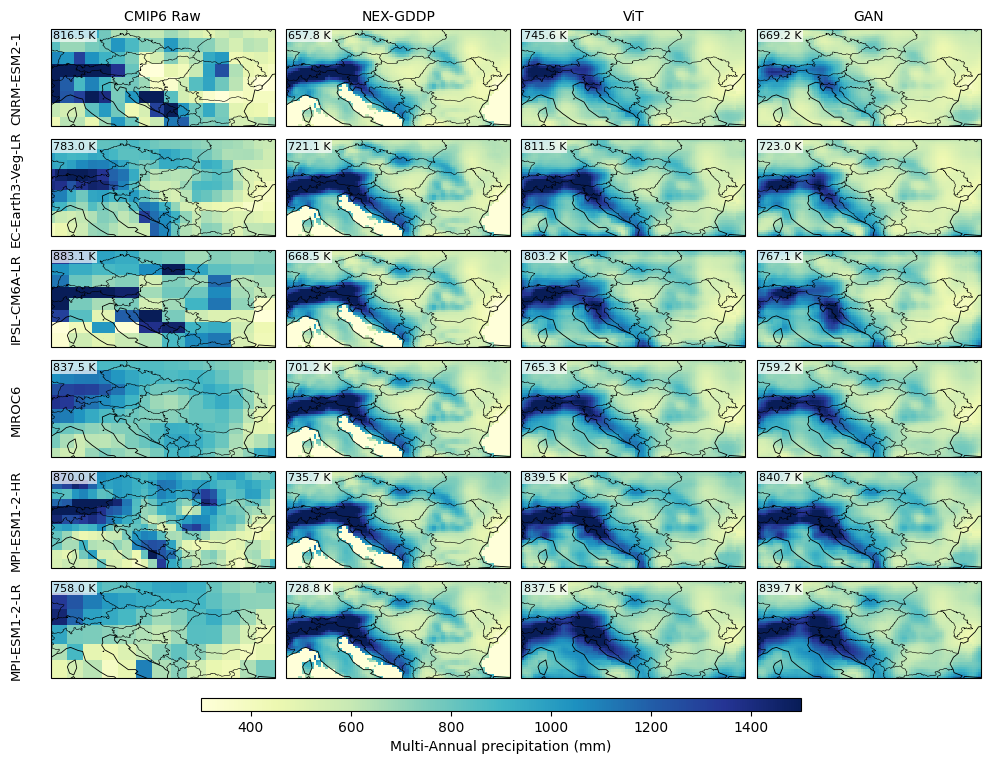

In [11]:


# --- Panel Plotting for Maps ---
dataset_order_for_maps = ['CMIP6 Raw', 'NEX-GDDP', 'ViT', 'GAN']
num_models_to_plot = len(valid_model_configs_for_maps)
num_datasets_per_model = len(dataset_order_for_maps)  # Should be 4

if num_models_to_plot == 0:
    print("No models available for map plotting.")
else:
    projection = ccrs.PlateCarree()

    fig_maps, axes_maps = plt.subplots(
        nrows=num_models_to_plot,
        ncols=num_datasets_per_model,
        figsize=(12, 8.5),
        subplot_kw={'projection': projection},
        squeeze=False
    )

    plot_mappable = None

    for i, config in enumerate(valid_model_configs_for_maps):
        model_name = config["name"]
        for j, ds_name in enumerate(dataset_order_for_maps):
            ax = axes_maps[i, j]

            current_map = all_ssp_mean_maps[model_name][ds_name]

            plot_mappable = current_map.plot(
                ax=ax,
                transform=ccrs.PlateCarree(),
                vmin=global_min_temp,
                vmax=global_max_temp,
                cmap='YlGnBu',
                add_colorbar=False
            )

            # Add mean areal value in top-left corner
            mean_val = float(current_map.mean().values)
            ax.text(
                0.01, 0.98,
                f"{mean_val:.1f} K",
                transform=ax.transAxes,
                fontsize=8,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=dict(facecolor='white', edgecolor='none', pad=1, alpha=0.7)
            )

            # Set title on top row
            ax.set_title(f"{ds_name}" if i == 0 else "", fontsize=10)

            # Coastlines and borders
            ax.coastlines(resolution='110m', linewidth=0.6)
            ax.add_feature(cfeature.BORDERS, linewidth=0.4)

            # Y-axis labels on first column only
            ax.set_ylabel(model_name if j == 0 else "", fontsize=9.5, rotation=90, labelpad=20)

            # X-axis labels on bottom row only
            if i == num_models_to_plot - 1:
                ax.tick_params(axis='x', labelsize=10)
                ax.set_xlabel('')
            else:
                ax.set_xticks([])
                ax.set_xticklabels([])
                ax.set_xlabel('')

            # Hide y-axis ticks and label font size
            ax.set_yticks([])
            ax.tick_params(axis='y', labelsize=10)

    if plot_mappable is not None:
        # --- Add a centered horizontal colorbar ---
        cbar_ax = fig_maps.add_axes([
            0.25,   # left
            0.07,   # bottom
            0.5,    # width
            0.015   # height
        ])

        cb = fig_maps.colorbar(
            plot_mappable,
            cax=cbar_ax,
            orientation='horizontal'
        )

        cb.ax.tick_params(labelsize=10)
        cb.set_label('Multi-Annual precipitation (mm)', size=10)

        # Adjust layout to make room for colorbar
        fig_maps.subplots_adjust(bottom=0.1, wspace=0.05, hspace=0.0)

    plt.show()


#### Changes

In [13]:


# --- 1. Calculate Difference Maps (SSP126 - Historical) ---
all_diff_mean_maps = {}
valid_model_configs_for_diff_maps = []
global_min_diff = np.inf
global_max_diff = -np.inf

print("Starting data processing for absolute change maps (SSP126 - Historical)...")

# Determine common models for which both historical and SSP maps exist
common_model_names = set(all_annual_mean_maps.keys()) & set(all_ssp_mean_maps.keys())

for config in model_configurations:
    model_name = config["name"]
    if model_name in common_model_names:
        # Ensure the model's data is fully present in both dictionaries
        if model_name not in all_annual_mean_maps or model_name not in all_ssp_mean_maps:
            print(f"Skipping difference calculation for {model_name}: data structure incomplete in historical or SSP maps dicts.")
            continue

        all_diff_mean_maps[model_name] = {}
        model_has_at_least_one_valid_diff_map = False

        for ds_name in dataset_order_for_maps:
            hist_map = all_annual_mean_maps[model_name].get(ds_name)
            ssp_map = all_ssp_mean_maps[model_name].get(ds_name)

            if hist_map is not None and ssp_map is not None:
                print(f"Calculating difference for {model_name} - {ds_name}")
                try:
                    # Basic check for coordinate compatibility (more robust checks might be needed for complex cases)
                    if not hist_map.coords.keys() == ssp_map.coords.keys() or \
                       not all(hist_map[c].equals(ssp_map[c]) for c in hist_map.coords if c in ssp_map.coords):
                        # Attempt to align/reindex if lat/lon are the differing coordinates and have same names
                        # This is a simple reindex, assumes target grid is ssp_map's grid if they differ slightly
                        # For more complex cases, explicit regridding might be needed earlier
                        print(f"Warning: Coordinate mismatch for {model_name} - {ds_name}. Attempting reindex.")
                        try:
                            hist_map_aligned = hist_map.reindex_like(ssp_map, method='nearest', tolerance=0.01) # Small tolerance for floating point
                            if not hist_map_aligned.coords.equals(ssp_map.coords): # Check again
                                raise ValueError("Reindexing failed to align coordinates.")
                            hist_map = hist_map_aligned
                        except Exception as reindex_e:
                            print(f"Reindexing failed for {model_name} - {ds_name}: {reindex_e}. Skipping difference.")
                            all_diff_mean_maps[model_name][ds_name] = None
                            continue

                    # Calculate percent change and load
                    diff_map = (((ssp_map - hist_map) / hist_map) * 100).load()
                    all_diff_mean_maps[model_name][ds_name] = diff_map
                    model_has_at_least_one_valid_diff_map = True

                    # Update global min/max for difference color scale
                    current_min = diff_map.min(skipna=True).item()
                    current_max = diff_map.max(skipna=True).item()
                    global_min_diff = -25
                    global_max_diff = 25
                except Exception as e:
                    print(f"Error calculating difference for {model_name} - {ds_name}: {e}")
                    all_diff_mean_maps[model_name][ds_name] = None
            else:
                print(f"Skipping difference for {model_name} - {ds_name}: Data missing in historical or SSP annual means.")
                all_diff_mean_maps[model_name][ds_name] = None
        
        if model_has_at_least_one_valid_diff_map:
            valid_model_configs_for_diff_maps.append(config)
    else:
        # Model not present in both historical and SSP processed maps, or not in original configurations
        if model_name in all_annual_mean_maps or model_name in all_ssp_mean_maps:
             print(f"Skipping difference calculation for {model_name}: not found in both historical and SSP map sets.")




Starting data processing for absolute change maps (SSP126 - Historical)...
Calculating difference for CNRM-ESM2-1 - CMIP6 Raw
Calculating difference for CNRM-ESM2-1 - NEX-GDDP
Calculating difference for CNRM-ESM2-1 - ViT
Calculating difference for CNRM-ESM2-1 - GAN
Calculating difference for EC-Earth3-Veg-LR - CMIP6 Raw
Calculating difference for EC-Earth3-Veg-LR - NEX-GDDP
Calculating difference for EC-Earth3-Veg-LR - ViT
Calculating difference for EC-Earth3-Veg-LR - GAN
Calculating difference for IPSL-CM6A-LR - CMIP6 Raw
Calculating difference for IPSL-CM6A-LR - NEX-GDDP
Calculating difference for IPSL-CM6A-LR - ViT
Calculating difference for IPSL-CM6A-LR - GAN
Calculating difference for MIROC6 - CMIP6 Raw
Calculating difference for MIROC6 - NEX-GDDP
Calculating difference for MIROC6 - ViT
Calculating difference for MIROC6 - GAN
Calculating difference for MPI-ESM1-2-HR - CMIP6 Raw
Calculating difference for MPI-ESM1-2-HR - NEX-GDDP
Calculating difference for MPI-ESM1-2-HR - ViT
Calcu

In [ ]:
all_diff_mean_maps['MPI-ESM1-2-HR']['GAN'].shape

Symmetric global precipitation difference range for maps: -25.00K to 25.00K
Data for difference maps prepared. Now plotting...


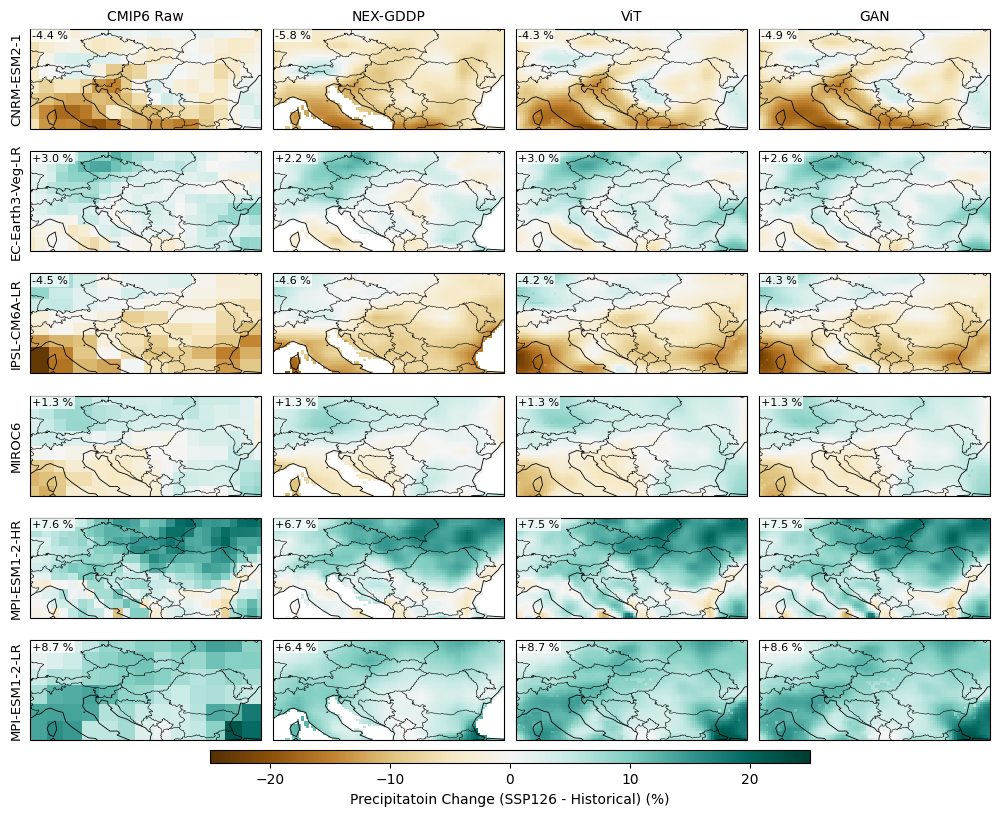

In [15]:
if not valid_model_configs_for_diff_maps:
    print("No models have sufficient data for plotting difference maps.")
elif global_min_diff == np.inf or global_max_diff == -np.inf:
    print("Could not determine a valid global precipitation difference range for color scale. Exiting difference map plotting.")
else:
    # Determine plotting range for differences, making it symmetric if it spans zero
    if global_min_diff < 0 and global_max_diff > 0:
        abs_max_val = max(abs(global_min_diff), abs(global_max_diff))
        plot_vmin_diff = -abs_max_val
        plot_vmax_diff = abs_max_val
        print(f"Symmetric global precipitation difference range for maps: {plot_vmin_diff:.2f}K to {plot_vmax_diff:.2f}K")
    else:
        plot_vmin_diff = global_min_diff
        plot_vmax_diff = global_max_diff
        print(f"Global precipitation difference range for maps: {plot_vmin_diff:.2f}K to {plot_vmax_diff:.2f}K")

    print("Data for difference maps prepared. Now plotting...")

    # --- 2. Panel Plotting for Difference Maps (SSP126 - Historical) ---
    num_models_to_plot_diff = len(valid_model_configs_for_diff_maps)
    num_datasets_per_model = len(dataset_order_for_maps)

    if num_models_to_plot_diff > 0:
        projection_diff = ccrs.PlateCarree()

        fig_diff_maps, axes_diff_maps = plt.subplots(
            nrows=num_models_to_plot_diff,
            ncols=num_datasets_per_model,
             figsize=(12, 8.5), # Adjusted height per row
            subplot_kw={'projection': projection_diff},
            squeeze=False # Ensures axes_diff_maps is always 2D
        )
       

        plot_mappable_diff = None # To store the last plotted mappable for the colorbar

        for i, config_diff in enumerate(valid_model_configs_for_diff_maps):
            model_name = config_diff["name"]
            for j, ds_name in enumerate(dataset_order_for_maps):
                ax = axes_diff_maps[i, j]
                current_diff_map = all_diff_mean_maps.get(model_name, {}).get(ds_name)

                if current_diff_map is not None and not current_diff_map.isnull().all():
                    plot_mappable_diff = current_diff_map.plot(
                        ax=ax,
                        transform=ccrs.PlateCarree(),
                        vmin=plot_vmin_diff,
                        vmax=plot_vmax_diff,
                        cmap='BrBG',  # Diverging colormap (Red for positive, Blue for negative)
                        add_colorbar=False # Colorbar will be added manually
                    )

                    mean_val_diff = float(current_diff_map.mean(skipna=True).values)
                    ax.text(
                        0.01, 0.98, f"{mean_val_diff:+.1f} %", # Show sign for difference
                        transform=ax.transAxes, fontsize=8, verticalalignment='top',
                        horizontalalignment='left', bbox=dict(facecolor='white', edgecolor='none', pad=1, alpha=0.7)
                    )
                else:
                    ax.text(0.5, 0.5, "Data N/A", ha="center", va="center", transform=ax.transAxes, fontsize=10)
                    ax.set_xticks([]) # Clear ticks for N/A plots
                    ax.set_yticks([])

                if i == 0: # Set dataset titles only on the top row
                    ax.set_title(ds_name, fontsize=10)
                else:
                    ax.set_title("")


                ax.coastlines(resolution='110m', linewidth=0.6)
                ax.add_feature(cfeature.BORDERS, linewidth=0.4)

                if j == 0: # Set model names as y-labels only on the first column
                    ax.set_ylabel(model_name, fontsize=9.5, rotation=90, labelpad=5) # Reduced labelpad
                
                # X-axis tick labels only on the bottom row
                ax.set_xticks([])
                ax.set_xticklabels([])
                ax.set_xlabel("")

                # Y-axis tick labels (lat) only on the leftmost plots if desired, or hide all
                # For consistency with original plots, hiding y-ticks for now
                ax.set_yticks([])
                ax.set_ylabel(ax.get_ylabel() if j==0 else "") # Keep y-label for first column, clear for others


        if plot_mappable_diff is not None:
            cbar_ax_diff = fig_diff_maps.add_axes([0.25, 0.08, 0.5, 0.015]) # left, bottom, width, height
            
            # Determine extend based on whether plotting range covers actual data range
            extend_cbar = 'neither'
            if plot_vmin_diff > global_min_diff and plot_vmax_diff < global_max_diff:
                extend_cbar = 'both'
            elif plot_vmin_diff > global_min_diff:
                extend_cbar = 'min'
            elif plot_vmax_diff < global_max_diff:
                extend_cbar = 'max'

            cb_diff = fig_diff_maps.colorbar(
                plot_mappable_diff,
                cax=cbar_ax_diff,
                orientation='horizontal',
                extend=extend_cbar
            )
            cb_diff.ax.tick_params(labelsize=10)
            cb_diff.set_label('Precipitatoin Change (SSP126 - Historical) (%)', size=10)

            fig_diff_maps.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.9, wspace=0.05, hspace=0.1)


        plt.show()

    else: # num_models_to_plot_diff == 0
        print("No models available to plot for differences after filtering.")

Data for difference PDFs prepared. Now plotting...


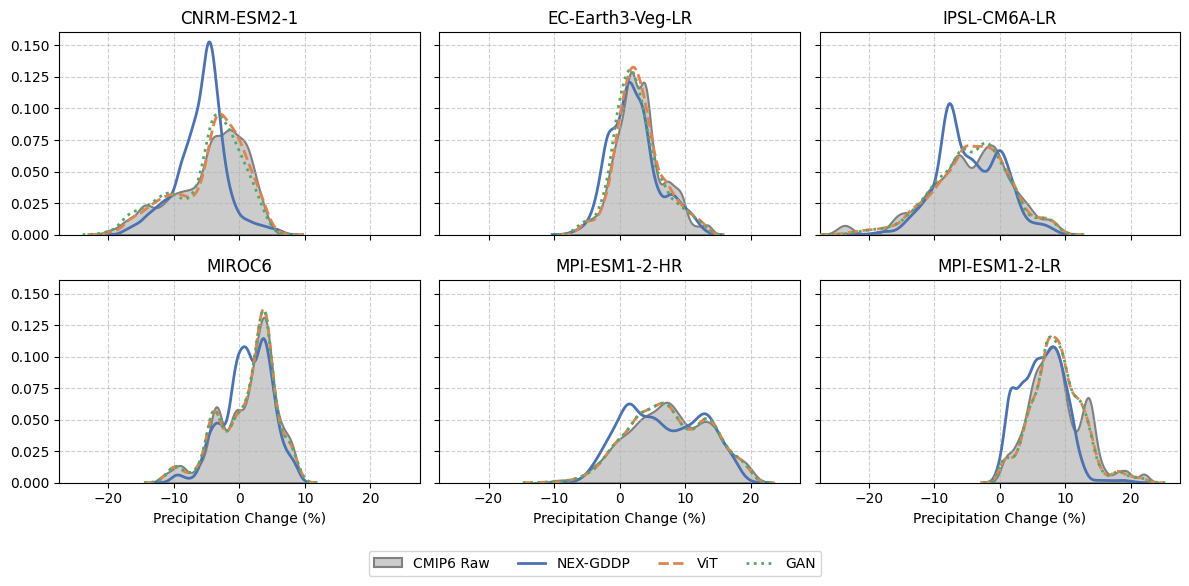

In [16]:

# --- PDF Plotting Section ---
if not valid_model_configs_for_diff_maps:
    print("No models have sufficient data for plotting difference PDFs.")
elif global_min_diff == np.inf or global_max_diff == -np.inf:
    print("Could not determine a valid global precipitation difference range. Exiting PDF plotting.")
else:
    print("Data for difference PDFs prepared. Now plotting...")

    num_models_to_plot_pdfs = len(valid_model_configs_for_diff_maps)

    if num_models_to_plot_pdfs > 0:
        # --- Define plot layout: 3 columns ---
        ncols_pdf = 3
        # Calculate number of rows needed based on models and columns
        nrows_pdf = (num_models_to_plot_pdfs + ncols_pdf - 1) // ncols_pdf

        fig_pdfs, axes_pdfs_flat = plt.subplots(
            nrows=nrows_pdf,
            ncols=ncols_pdf,
            figsize=(4 * ncols_pdf, 3 * nrows_pdf), # Adjust width per col, height per row
            sharex=True,  # All PDF plots will share the same x-axis (precipitation Change)
            sharey=True,  # Optionally share y-axis for consistent density scaling
            squeeze=False
        )
        axes_pdfs_flat = axes_pdfs_flat.flatten() # Flatten for easy iteration


        # --- Define a color palette and line styles ---
        # First dataset (e.g., 'CMIP6 Raw') special handling
        first_dataset_name = dataset_order_for_maps[0]
        other_dataset_names = dataset_order_for_maps[1:]

        # Colors for 'other' datasets (lines)
        # Using a qualitative palette, skipping gray-like colors if possible
        line_colors = sns.color_palette("deep", n_colors=len(other_dataset_names))
        
        # Line styles for 'other' datasets to further differentiate
        line_styles = ['-', '--', ':', '-.'] * (len(other_dataset_names) // 4 + 1)


        for i, config_pdf in enumerate(valid_model_configs_for_diff_maps):
            model_name = config_pdf["name"]
            ax = axes_pdfs_flat[i]  # Current axis for this model's PDF plot

            has_data_for_this_subplot = False

            # 1. Plot the first dataset (e.g., 'CMIP6 Raw') with gray shading
            current_diff_map_first = all_diff_mean_maps.get(model_name, {}).get(first_dataset_name)
            if current_diff_map_first is not None and not current_diff_map_first.isnull().all():
                data_values_first = current_diff_map_first.data.flatten()
                data_values_first = data_values_first[~np.isnan(data_values_first)]
                if data_values_first.size > 1:
                    sns.kdeplot(
                        data_values_first,
                        ax=ax,
                        label=first_dataset_name,
                        color='gray',    # Gray color
                        fill=True,       # Fill under the KDE curve
                        alpha=0.4,       # Transparency for the fill
                        linewidth=1.5,   # Slightly thicker line for the filled area
                        zorder=1         # Ensure it's plotted behind other lines
                    )
                    has_data_for_this_subplot = True
                else:
                    print(f"Warning: Not enough data for KDE for {model_name} - {first_dataset_name} (found {data_values_first.size}).")


            # 2. Plot other datasets as lines
            for k, ds_name in enumerate(other_dataset_names):
                current_diff_map = all_diff_mean_maps.get(model_name, {}).get(ds_name)
                if current_diff_map is not None and not current_diff_map.isnull().all():
                    data_values = current_diff_map.data.flatten()
                    data_values = data_values[~np.isnan(data_values)]

                    if data_values.size > 1:
                        sns.kdeplot(
                            data_values,
                            ax=ax,
                            label=ds_name,
                            color=line_colors[k % len(line_colors)], # Cycle through colors
                            linestyle=line_styles[k % len(line_styles)], # Cycle through linestyles
                            linewidth=2,    # Make lines prominent
                            fill=False,     # No fill for these
                            zorder=2 + k    # Ensure lines are on top of fill and each other
                        )
                        has_data_for_this_subplot = True
                    else:
                        print(f"Warning: Not enough data for KDE for {model_name} - {ds_name} (found {data_values.size}).")
                else:
                    print(f"Info: No diff map data for {model_name} - {ds_name} to plot PDF.")

            ax.set_title(model_name, fontsize=12) # Slightly smaller title for more plots

            if i % ncols_pdf == 0: # Only show Y-label on the first column of plots
                ax.set_ylabel("", fontsize=10)
            else:
                ax.set_ylabel("") # Clear y-label for other columns

            if i >= num_models_to_plot_pdfs - ncols_pdf : # Only show X-label on the bottom row of plots
                 ax.set_xlabel("Precipitation Change (%)", fontsize=10)
            else:
                ax.set_xlabel("") # Clear x-label for other rows


            ax.grid(True, linestyle='--', alpha=0.6)

            # Common x-axis limits
            x_padding = (plot_vmax_diff - plot_vmin_diff) * 0.05
            ax.set_xlim(plot_vmin_diff - x_padding, plot_vmax_diff + x_padding)
            
            # Y-axis limits (optional, if sharey=True is used and you want to fix them)
            # You might need to run once to see typical density ranges, or calculate global max density
            # ax.set_ylim(0, some_max_density_value)


        # --- Create a single legend for the entire figure ---
        # Get handles and labels from one of the axes that has plotted data
        # It's a bit tricky if some plots are empty. We'll try from the first.
        handles, labels = [], []
        for ax_check in axes_pdfs_flat:
            if ax_check.get_legend_handles_labels()[0]: # if it has any handles
                handles, labels = ax_check.get_legend_handles_labels()
                # Remove individual legends from subplots now that we'll have a common one
                if ax_check.get_legend() is not None:
                    ax_check.get_legend().remove()
                break # Found handles, no need to check further

        if handles: # If we got any handles
            # Manually order handles and labels to match dataset_order_for_maps
            ordered_handles_labels = []
            for ds_name_ordered in dataset_order_for_maps:
                try:
                    idx = labels.index(ds_name_ordered)
                    ordered_handles_labels.append((handles[idx], labels[idx]))
                except ValueError:
                    pass # This dataset might not have been plotted in the first subplot
            
            if ordered_handles_labels:
                final_handles, final_labels = zip(*ordered_handles_labels)
                fig_pdfs.legend(
                    final_handles, final_labels,
                    loc='lower center', # Position the legend
                    bbox_to_anchor=(0.5, -0.02 if nrows_pdf > 1 else 0.01), # Adjust based on rows
                    ncol=len(dataset_order_for_maps), # Number of columns in legend
                    fontsize=10,
                    title_fontsize=11
                )
            else:
                 print("Warning: Could not create a common legend; no plottable data found for initial legend creation.")
        else:
            print("Warning: Could not create a common legend; no handles/labels found.")


        # --- Hide unused axes if num_models < nrows * ncols ---
        for j in range(num_models_to_plot_pdfs, nrows_pdf * ncols_pdf):
            fig_pdfs.delaxes(axes_pdfs_flat[j])

        # Adjust layout
        fig_pdfs.tight_layout(rect=[0, 0.05, 1, 0.96]) # rect=[left, bottom, right, top]

        plt.show()

    else: # num_models_to_plot_pdfs == 0
        print("No models available to plot PDFs after filtering.")

In [ ]:
np.nanmax(all_annual_mean_maps['CNRM-ESM2-1']['CMIP6 Raw'].values)

In [ ]:
for model in valid_model_configs_for_diff_maps:
    model_name = model["name"]
    for ds_name in dataset_order_for_maps:
        m = all_diff_mean_maps.get(model_name, {}).get(ds_name)
        if m is None:
            print(f"Missing map for model: {model_name}, dataset: {ds_name}")


In [ ]:
valid_model_configs_for_diff_maps[0]

### SSP 585

In [18]:
# --- Main data processing and aggregation loop ---
all_plot_data_list = []
valid_model_configs_processed = [] # Store configs for models that were successfully processed
historical_years = range(2015, 2101) # Defines years 1950-2014
validation_start_year = 2071
validation_end_year = 2100
period = 'ssp585'

print("Starting data processing for all configured models...")
for config in model_configurations:
    model_data_dict, model_name_processed = process_model_data(config, historical_years,period, validation_start_year, validation_end_year)
    
    if model_data_dict and model_name_processed:
        valid_model_configs_processed.append(config) # Add config for successfully processed model
        
        for ds_name, ds_xarray in model_data_dict.items():
            # Data is already loaded into memory by process_model_data function
            for month_int, group_data in ds_xarray.groupby('time.month'):
                month_label = month_names[month_int - 1]
                
                # Flatten spatial and temporal (within month) dimensions, then remove NaNs
                values = group_data.data.flatten() 
                values = values[~np.isnan(values)]
                
                for val in values:
                    all_plot_data_list.append({
                        'Model_Name': model_name_processed,
                        'Month': month_label,
                        'Month_Num': month_int, # For sorting
                        'Dataset': ds_name,
                        'Precipitation (mm)': val
                    })
    else:
        print(f"Failed to retrieve or process data for model: {config.get('name', 'Unknown Model')}. It will be excluded from the plot.")


df_plot_all = pd.DataFrame(all_plot_data_list)


# Prepare DataFrame for plotting: set 'Month' as categorical for correct order
df_plot_all['Month'] = pd.Categorical(df_plot_all['Month'], categories=month_names, ordered=True)
# Sort values for consistent processing, though seaborn handles categorical order
df_plot_all = df_plot_all.sort_values(by=['Model_Name', 'Month_Num', 'Dataset'])

print("Data aggregation complete. Preparing to plot...")


Starting data processing for all configured models...
2015
2100
--- Processing model: CNRM-ESM2-1 ---
Loading NEX-GDDP for CNRM-ESM2-1...
Loading CMIP6 Raw for CNRM-ESM2-1...
Loading ViT downscaled for CNRM-ESM2-1...
Loading GAN downscaled for CNRM-ESM2-1...
2015
2100
--- Processing model: EC-Earth3-Veg-LR ---
Loading NEX-GDDP for EC-Earth3-Veg-LR...
Loading CMIP6 Raw for EC-Earth3-Veg-LR...
Loading ViT downscaled for EC-Earth3-Veg-LR...
Loading GAN downscaled for EC-Earth3-Veg-LR...
2015
2100
--- Processing model: IPSL-CM6A-LR ---
Loading NEX-GDDP for IPSL-CM6A-LR...
Loading CMIP6 Raw for IPSL-CM6A-LR...
Loading ViT downscaled for IPSL-CM6A-LR...
Loading GAN downscaled for IPSL-CM6A-LR...
2015
2100
--- Processing model: MIROC6 ---
Loading NEX-GDDP for MIROC6...
Loading CMIP6 Raw for MIROC6...
Loading ViT downscaled for MIROC6...
Loading GAN downscaled for MIROC6...
2015
2100
--- Processing model: MPI-ESM1-2-HR ---
Loading NEX-GDDP for MPI-ESM1-2-HR...
Loading CMIP6 Raw for MPI-ESM1-2-

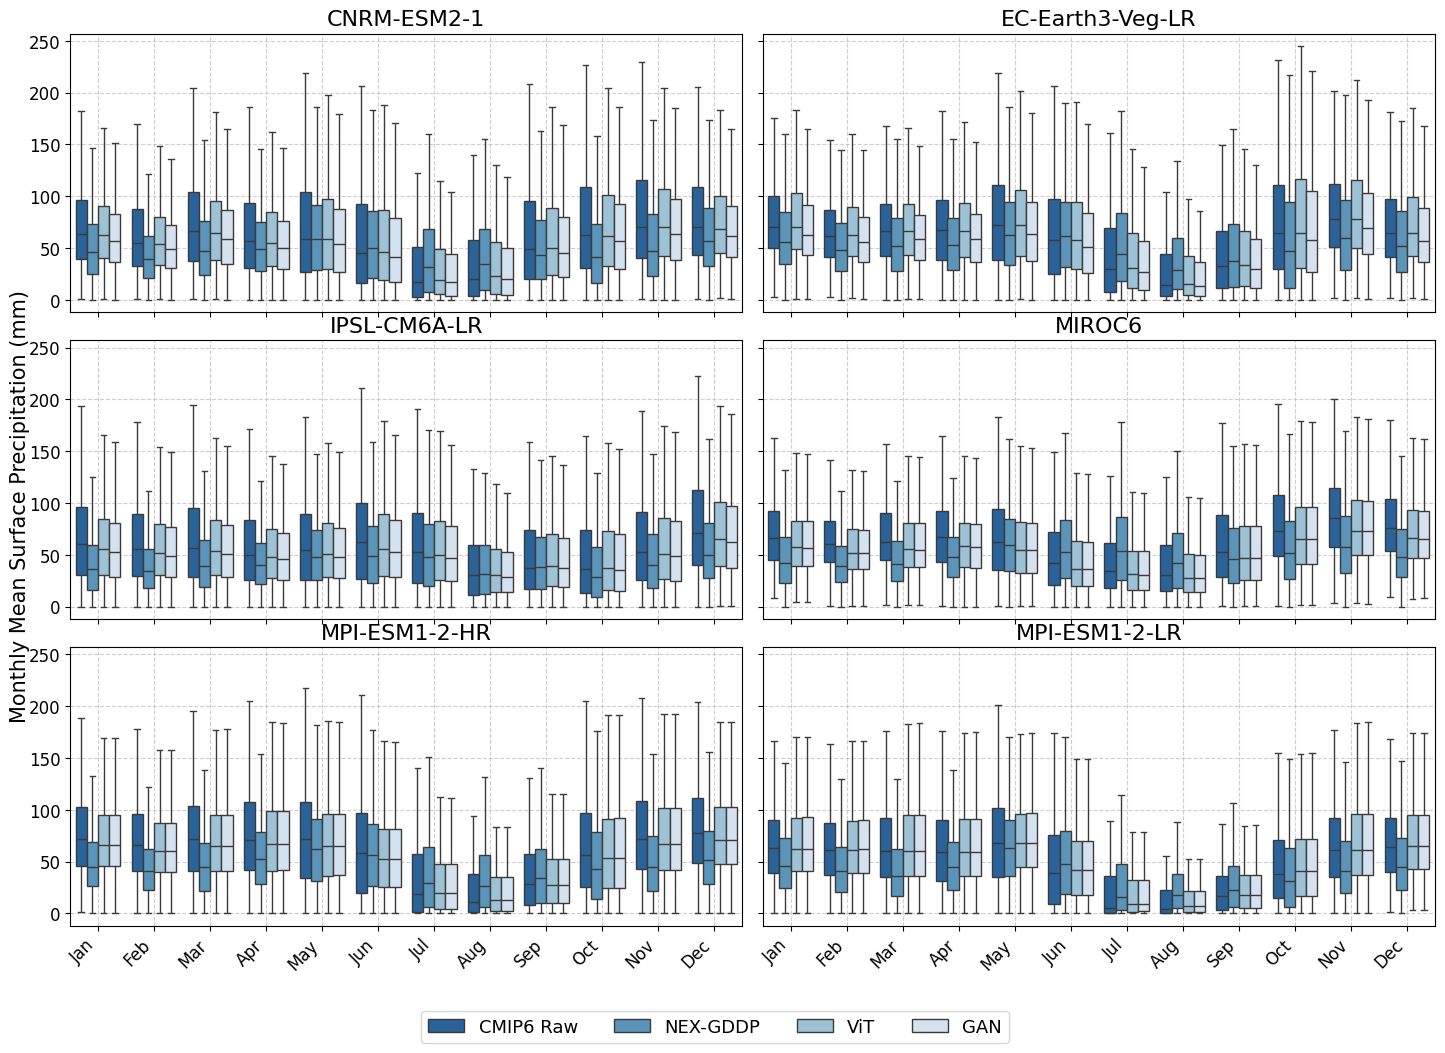

In [19]:

# --- Panel Plotting ---
num_models_to_plot = len(valid_model_configs_processed)

# Determine grid size for subplots (e.g., 2 columns)
ncols = 2 
nrows = (num_models_to_plot + ncols - 1) // ncols # Ceiling division to get enough rows

fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(7.5 * ncols, 3.5 * nrows), # Adjust figsize as needed
    sharey=True, # All subplots share the same y-axis scale
    sharex=True  # All subplots share the same x-axis (months)
)
axes = np.array(axes).flatten() # Flatten axes array for easy iteration

handles, labels = None, None # To store legend items from the first plot

for i, config in enumerate(valid_model_configs_processed):
    ax = axes[i]
    current_model_name = config["name"]
    
    # Filter data for the current model
    df_model = df_plot_all[df_plot_all['Model_Name'] == current_model_name]

    sns.boxplot(
        x='Month', 
        y='Precipitation (mm)', 
        hue='Dataset', 
        data=df_model,
        hue_order=desired_hue_order, # Ensure consistent dataset order
        palette='Blues_r', # Color palette
        showfliers=False, # Do not show outliers to keep plots cleaner
        ax=ax,
        legend= (i == 0) # Generate legend items only for the first plot
    )
    
    ax.set_title(current_model_name, fontsize=16)
    ax.set_xlabel('') # Individual x-labels turned off for shared axis
    ax.set_ylabel('') # Individual y-labels turned off for shared axis

    # --- CORRECTED TICK PARAMETERS ---
    # Apply styling to x-axis tick labels: rotation and size
    ax.tick_params(axis='x', labelrotation=45, labelsize=12)
    # Set horizontal alignment for the rotated x-tick labels
    plt.setp(ax.get_xticklabels(), ha='right') 
    
    # Apply styling to y-axis tick labels: size
    ax.tick_params(axis='y', labelsize=12)
    # --- END CORRECTION ---
    
    ax.grid(True, linestyle='--', alpha=0.6)

    # Capture legend handles and labels from the first plot that has a legend
    if i == 0 and ax.get_legend() is not None:
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove() # Remove legend from the subplot itself


# Set common (super) labels for the entire figure
fig.supxlabel('') 
fig.supylabel('Monthly Mean Surface Precipitation (mm)', fontsize=15, x=0.03)

# Add a single, shared legend to the figure

fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02 if nrows >=3 else -0.005), ncol=len(desired_hue_order), fontsize=13)
plt.subplots_adjust(left=0.07, right=0.98, top=0.95,  bottom=0.1,  hspace=0.1,wspace=0.03)


plt.show()


In [20]:
all_ssp_mean_maps = {} # Structure: {model_name: {dataset_name: xr.DataArray}}
valid_model_configs_for_maps = []
global_min_temp = np.inf
global_max_temp = -np.inf

print("Starting data processing for multi-annual mean maps...")
for config in model_configurations:
    model_monthly_data, model_name =  process_model_data(config, historical_years,period, validation_start_year, validation_end_year)
    
    if model_monthly_data and 'NEX-GDDP' in model_monthly_data: # Ensure base data exists
        valid_model_configs_for_maps.append(config)
        all_ssp_mean_maps[model_name] = {}
        
        for ds_name, ds_xarray_monthly in model_monthly_data.items():
            print(f"Calculating annual mean for {model_name} - {ds_name}")
            try:
                # Calculate mean over the 'time' dimension (all months, all years)
                annual_sums = ds_xarray_monthly.resample(time='1YE').sum(dim='time', skipna=True)

                    # Step 2: Compute multi-annual mean of the annual sums
                annual_mean_map = annual_sums.mean(dim='time', skipna=True).load()
                all_ssp_mean_maps[model_name][ds_name] = annual_mean_map
                
                # Update global min/max for color scale
                current_min = 300
                current_max = 1500
                if not np.isnan(current_min):
                    global_min_temp = min(global_min_temp, current_min)
                if not np.isnan(current_max):
                    global_max_temp = max(global_max_temp, current_max)
            except Exception as e:
                print(f"Error calculating annual mean for {model_name} - {ds_name}: {e}")
                all_ssp_mean_maps[model_name][ds_name] = None # Mark as failed
    else:
        print(f"Skipping maps for model: {config.get('name', 'Unknown Model')} due to missing data.")

if not valid_model_configs_for_maps:
    print("No models have sufficient data for plotting annual mean maps. Exiting.")
    # exit() # Or handle
elif global_min_temp == np.inf or global_max_temp == -np.inf:
    print("Could not determine a valid global precipitation range for color scale. Exiting map plotting.")
    # exit() # Or handle

print(f"Global precipitation range for maps: {global_min_temp:.2f}K to {global_max_temp:.2f}K")
print("Data for maps prepared. Now plotting...")

Starting data processing for multi-annual mean maps...
2015
2100
--- Processing model: CNRM-ESM2-1 ---
Loading NEX-GDDP for CNRM-ESM2-1...
Loading CMIP6 Raw for CNRM-ESM2-1...
Loading ViT downscaled for CNRM-ESM2-1...
Loading GAN downscaled for CNRM-ESM2-1...
Calculating annual mean for CNRM-ESM2-1 - NEX-GDDP
Calculating annual mean for CNRM-ESM2-1 - CMIP6 Raw
Calculating annual mean for CNRM-ESM2-1 - ViT
Calculating annual mean for CNRM-ESM2-1 - GAN
2015
2100
--- Processing model: EC-Earth3-Veg-LR ---
Loading NEX-GDDP for EC-Earth3-Veg-LR...
Loading CMIP6 Raw for EC-Earth3-Veg-LR...
Loading ViT downscaled for EC-Earth3-Veg-LR...
Loading GAN downscaled for EC-Earth3-Veg-LR...
Calculating annual mean for EC-Earth3-Veg-LR - NEX-GDDP
Calculating annual mean for EC-Earth3-Veg-LR - CMIP6 Raw
Calculating annual mean for EC-Earth3-Veg-LR - ViT
Calculating annual mean for EC-Earth3-Veg-LR - GAN
2015
2100
--- Processing model: IPSL-CM6A-LR ---
Loading NEX-GDDP for IPSL-CM6A-LR...
Loading CMIP6 

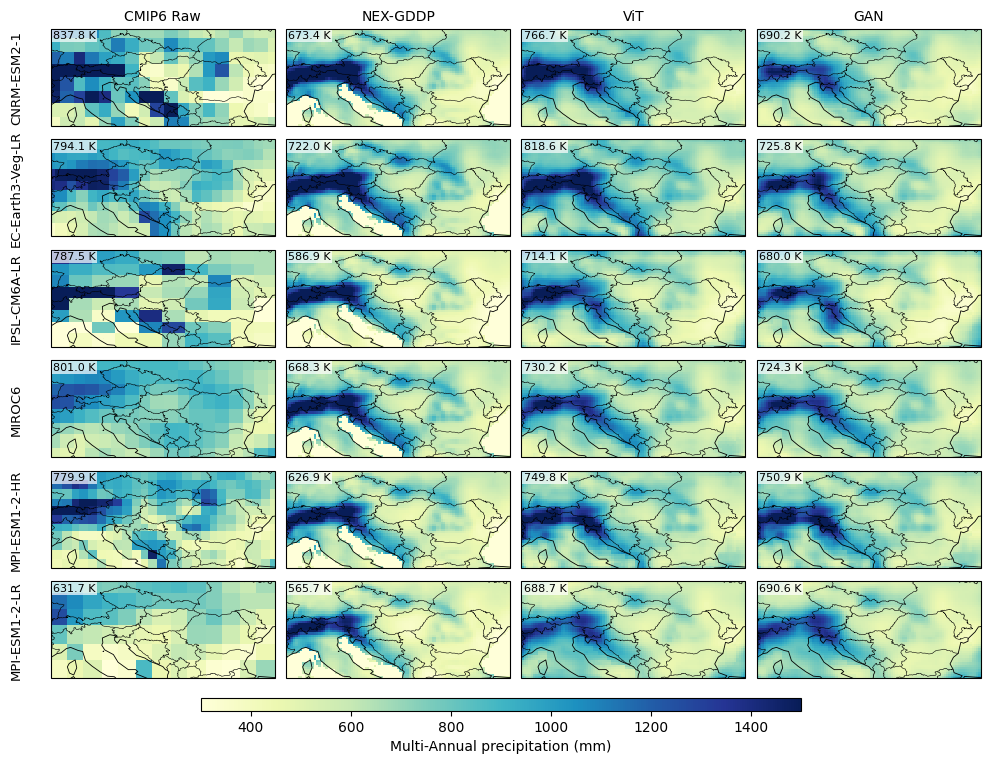

In [21]:


# --- Panel Plotting for Maps ---
dataset_order_for_maps = ['CMIP6 Raw', 'NEX-GDDP', 'ViT', 'GAN']
num_models_to_plot = len(valid_model_configs_for_maps)
num_datasets_per_model = len(dataset_order_for_maps)  # Should be 4

if num_models_to_plot == 0:
    print("No models available for map plotting.")
else:
    projection = ccrs.PlateCarree()

    fig_maps, axes_maps = plt.subplots(
        nrows=num_models_to_plot,
        ncols=num_datasets_per_model,
        figsize=(12, 8.5),
        subplot_kw={'projection': projection},
        squeeze=False
    )

    plot_mappable = None

    for i, config in enumerate(valid_model_configs_for_maps):
        model_name = config["name"]
        for j, ds_name in enumerate(dataset_order_for_maps):
            ax = axes_maps[i, j]

            current_map = all_ssp_mean_maps[model_name][ds_name]

            plot_mappable = current_map.plot(
                ax=ax,
                transform=ccrs.PlateCarree(),
                vmin=global_min_temp,
                vmax=global_max_temp,
                cmap='YlGnBu',
                add_colorbar=False
            )

            # Add mean areal value in top-left corner
            mean_val = float(current_map.mean().values)
            ax.text(
                0.01, 0.98,
                f"{mean_val:.1f} K",
                transform=ax.transAxes,
                fontsize=8,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=dict(facecolor='white', edgecolor='none', pad=1, alpha=0.7)
            )

            # Set title on top row
            ax.set_title(f"{ds_name}" if i == 0 else "", fontsize=10)

            # Coastlines and borders
            ax.coastlines(resolution='110m', linewidth=0.6)
            ax.add_feature(cfeature.BORDERS, linewidth=0.4)

            # Y-axis labels on first column only
            ax.set_ylabel(model_name if j == 0 else "", fontsize=9.5, rotation=90, labelpad=20)

            # X-axis labels on bottom row only
            if i == num_models_to_plot - 1:
                ax.tick_params(axis='x', labelsize=10)
                ax.set_xlabel('')
            else:
                ax.set_xticks([])
                ax.set_xticklabels([])
                ax.set_xlabel('')

            # Hide y-axis ticks and label font size
            ax.set_yticks([])
            ax.tick_params(axis='y', labelsize=10)

    if plot_mappable is not None:
        # --- Add a centered horizontal colorbar ---
        cbar_ax = fig_maps.add_axes([
            0.25,   # left
            0.07,   # bottom
            0.5,    # width
            0.015   # height
        ])

        cb = fig_maps.colorbar(
            plot_mappable,
            cax=cbar_ax,
            orientation='horizontal'
        )

        cb.ax.tick_params(labelsize=10)
        cb.set_label('Multi-Annual precipitation (mm)', size=10)

        # Adjust layout to make room for colorbar
        fig_maps.subplots_adjust(bottom=0.1, wspace=0.05, hspace=0.0)

    plt.show()


In [22]:


# --- 1. Calculate relative Difference Maps (SSP585 - Historical) ---
all_diff_mean_maps = {}
valid_model_configs_for_diff_maps = []
global_min_diff = np.inf
global_max_diff = -np.inf

print("Starting data processing for absolute change maps (SSP585 - Historical)...")

# Determine common models for which both historical and SSP maps exist
common_model_names = set(all_annual_mean_maps.keys()) & set(all_ssp_mean_maps.keys())

for config in model_configurations:
    model_name = config["name"]
    if model_name in common_model_names:
        # Ensure the model's data is fully present in both dictionaries
        if model_name not in all_annual_mean_maps or model_name not in all_ssp_mean_maps:
            print(f"Skipping difference calculation for {model_name}: data structure incomplete in historical or SSP maps dicts.")
            continue

        all_diff_mean_maps[model_name] = {}
        model_has_at_least_one_valid_diff_map = False

        for ds_name in dataset_order_for_maps:
            hist_map = all_annual_mean_maps[model_name].get(ds_name)
            ssp_map = all_ssp_mean_maps[model_name].get(ds_name)

            if hist_map is not None and ssp_map is not None:
                print(f"Calculating difference for {model_name} - {ds_name}")
                try:
                    # Basic check for coordinate compatibility (more robust checks might be needed for complex cases)
                    if not hist_map.coords.keys() == ssp_map.coords.keys() or \
                       not all(hist_map[c].equals(ssp_map[c]) for c in hist_map.coords if c in ssp_map.coords):
                        # Attempt to align/reindex if lat/lon are the differing coordinates and have same names
                        # This is a simple reindex, assumes target grid is ssp_map's grid if they differ slightly
                        # For more complex cases, explicit regridding might be needed earlier
                        print(f"Warning: Coordinate mismatch for {model_name} - {ds_name}. Attempting reindex.")
                        try:
                            hist_map_aligned = hist_map.reindex_like(ssp_map, method='nearest', tolerance=0.01) # Small tolerance for floating point
                            if not hist_map_aligned.coords.equals(ssp_map.coords): # Check again
                                raise ValueError("Reindexing failed to align coordinates.")
                            hist_map = hist_map_aligned
                        except Exception as reindex_e:
                            print(f"Reindexing failed for {model_name} - {ds_name}: {reindex_e}. Skipping difference.")
                            all_diff_mean_maps[model_name][ds_name] = None
                            continue

                    # Calculate percent change and load
                    diff_map = (((ssp_map - hist_map) / hist_map) * 100).load()
                    all_diff_mean_maps[model_name][ds_name] = diff_map
                    model_has_at_least_one_valid_diff_map = True

                    # Update global min/max for difference color scale
                    current_min = diff_map.min(skipna=True).item()
                    current_max = diff_map.max(skipna=True).item()
                    global_min_diff = -25
                    global_max_diff = 25
                except Exception as e:
                    print(f"Error calculating difference for {model_name} - {ds_name}: {e}")
                    all_diff_mean_maps[model_name][ds_name] = None
            else:
                print(f"Skipping difference for {model_name} - {ds_name}: Data missing in historical or SSP annual means.")
                all_diff_mean_maps[model_name][ds_name] = None
        
        if model_has_at_least_one_valid_diff_map:
            valid_model_configs_for_diff_maps.append(config)
    else:
        # Model not present in both historical and SSP processed maps, or not in original configurations
        if model_name in all_annual_mean_maps or model_name in all_ssp_mean_maps:
             print(f"Skipping difference calculation for {model_name}: not found in both historical and SSP map sets.")




Starting data processing for absolute change maps (SSP585 - Historical)...
Calculating difference for CNRM-ESM2-1 - CMIP6 Raw
Calculating difference for CNRM-ESM2-1 - NEX-GDDP
Calculating difference for CNRM-ESM2-1 - ViT
Calculating difference for CNRM-ESM2-1 - GAN
Calculating difference for EC-Earth3-Veg-LR - CMIP6 Raw
Calculating difference for EC-Earth3-Veg-LR - NEX-GDDP
Calculating difference for EC-Earth3-Veg-LR - ViT
Calculating difference for EC-Earth3-Veg-LR - GAN
Calculating difference for IPSL-CM6A-LR - CMIP6 Raw
Calculating difference for IPSL-CM6A-LR - NEX-GDDP
Calculating difference for IPSL-CM6A-LR - ViT
Calculating difference for IPSL-CM6A-LR - GAN
Calculating difference for MIROC6 - CMIP6 Raw
Calculating difference for MIROC6 - NEX-GDDP
Calculating difference for MIROC6 - ViT
Calculating difference for MIROC6 - GAN
Calculating difference for MPI-ESM1-2-HR - CMIP6 Raw
Calculating difference for MPI-ESM1-2-HR - NEX-GDDP
Calculating difference for MPI-ESM1-2-HR - ViT
Calcu

Symmetric global precipitation difference range for maps: -25.00K to 25.00K
Data for difference maps prepared. Now plotting...


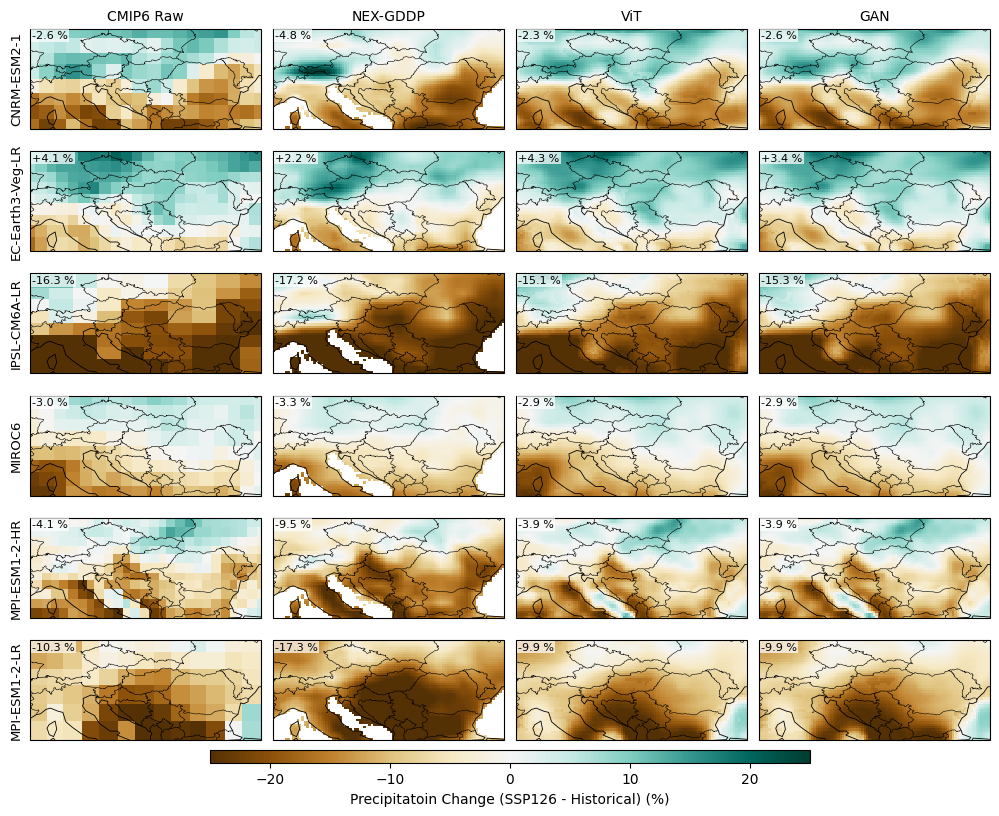

In [23]:
if not valid_model_configs_for_diff_maps:
    print("No models have sufficient data for plotting difference maps.")
elif global_min_diff == np.inf or global_max_diff == -np.inf:
    print("Could not determine a valid global precipitation difference range for color scale. Exiting difference map plotting.")
else:
    # Determine plotting range for differences, making it symmetric if it spans zero
    if global_min_diff < 0 and global_max_diff > 0:
        abs_max_val = max(abs(global_min_diff), abs(global_max_diff))
        plot_vmin_diff = -abs_max_val
        plot_vmax_diff = abs_max_val
        print(f"Symmetric global precipitation difference range for maps: {plot_vmin_diff:.2f}K to {plot_vmax_diff:.2f}K")
    else:
        plot_vmin_diff = global_min_diff
        plot_vmax_diff = global_max_diff
        print(f"Global precipitation difference range for maps: {plot_vmin_diff:.2f}K to {plot_vmax_diff:.2f}K")

    print("Data for difference maps prepared. Now plotting...")

    # --- 2. Panel Plotting for Difference Maps (SSP126 - Historical) ---
    num_models_to_plot_diff = len(valid_model_configs_for_diff_maps)
    num_datasets_per_model = len(dataset_order_for_maps)

    if num_models_to_plot_diff > 0:
        projection_diff = ccrs.PlateCarree()

        fig_diff_maps, axes_diff_maps = plt.subplots(
            nrows=num_models_to_plot_diff,
            ncols=num_datasets_per_model,
             figsize=(12, 8.5), # Adjusted height per row
            subplot_kw={'projection': projection_diff},
            squeeze=False # Ensures axes_diff_maps is always 2D
        )
       

        plot_mappable_diff = None # To store the last plotted mappable for the colorbar

        for i, config_diff in enumerate(valid_model_configs_for_diff_maps):
            model_name = config_diff["name"]
            for j, ds_name in enumerate(dataset_order_for_maps):
                ax = axes_diff_maps[i, j]
                current_diff_map = all_diff_mean_maps.get(model_name, {}).get(ds_name)

                if current_diff_map is not None and not current_diff_map.isnull().all():
                    plot_mappable_diff = current_diff_map.plot(
                        ax=ax,
                        transform=ccrs.PlateCarree(),
                        vmin=plot_vmin_diff,
                        vmax=plot_vmax_diff,
                        cmap='BrBG',  # Diverging colormap (Red for positive, Blue for negative)
                        add_colorbar=False # Colorbar will be added manually
                    )

                    mean_val_diff = float(current_diff_map.mean(skipna=True).values)
                    ax.text(
                        0.01, 0.98, f"{mean_val_diff:+.1f} %", # Show sign for difference
                        transform=ax.transAxes, fontsize=8, verticalalignment='top',
                        horizontalalignment='left', bbox=dict(facecolor='white', edgecolor='none', pad=1, alpha=0.7)
                    )
                else:
                    ax.text(0.5, 0.5, "Data N/A", ha="center", va="center", transform=ax.transAxes, fontsize=10)
                    ax.set_xticks([]) # Clear ticks for N/A plots
                    ax.set_yticks([])

                if i == 0: # Set dataset titles only on the top row
                    ax.set_title(ds_name, fontsize=10)
                else:
                    ax.set_title("")


                ax.coastlines(resolution='110m', linewidth=0.6)
                ax.add_feature(cfeature.BORDERS, linewidth=0.4)

                if j == 0: # Set model names as y-labels only on the first column
                    ax.set_ylabel(model_name, fontsize=9.5, rotation=90, labelpad=5) # Reduced labelpad
                
                # X-axis tick labels only on the bottom row
                ax.set_xticks([])
                ax.set_xticklabels([])
                ax.set_xlabel("")

                # Y-axis tick labels (lat) only on the leftmost plots if desired, or hide all
                # For consistency with original plots, hiding y-ticks for now
                ax.set_yticks([])
                ax.set_ylabel(ax.get_ylabel() if j==0 else "") # Keep y-label for first column, clear for others


        if plot_mappable_diff is not None:
            cbar_ax_diff = fig_diff_maps.add_axes([0.25, 0.08, 0.5, 0.015]) # left, bottom, width, height
            
            # Determine extend based on whether plotting range covers actual data range
            extend_cbar = 'neither'
            if plot_vmin_diff > global_min_diff and plot_vmax_diff < global_max_diff:
                extend_cbar = 'both'
            elif plot_vmin_diff > global_min_diff:
                extend_cbar = 'min'
            elif plot_vmax_diff < global_max_diff:
                extend_cbar = 'max'

            cb_diff = fig_diff_maps.colorbar(
                plot_mappable_diff,
                cax=cbar_ax_diff,
                orientation='horizontal',
                extend=extend_cbar
            )
            cb_diff.ax.tick_params(labelsize=10)
            cb_diff.set_label('Precipitatoin Change (SSP126 - Historical) (%)', size=10)

            fig_diff_maps.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.9, wspace=0.05, hspace=0.1)


        plt.show()

    else: # num_models_to_plot_diff == 0
        print("No models available to plot for differences after filtering.")

Data for difference PDFs prepared. Now plotting...


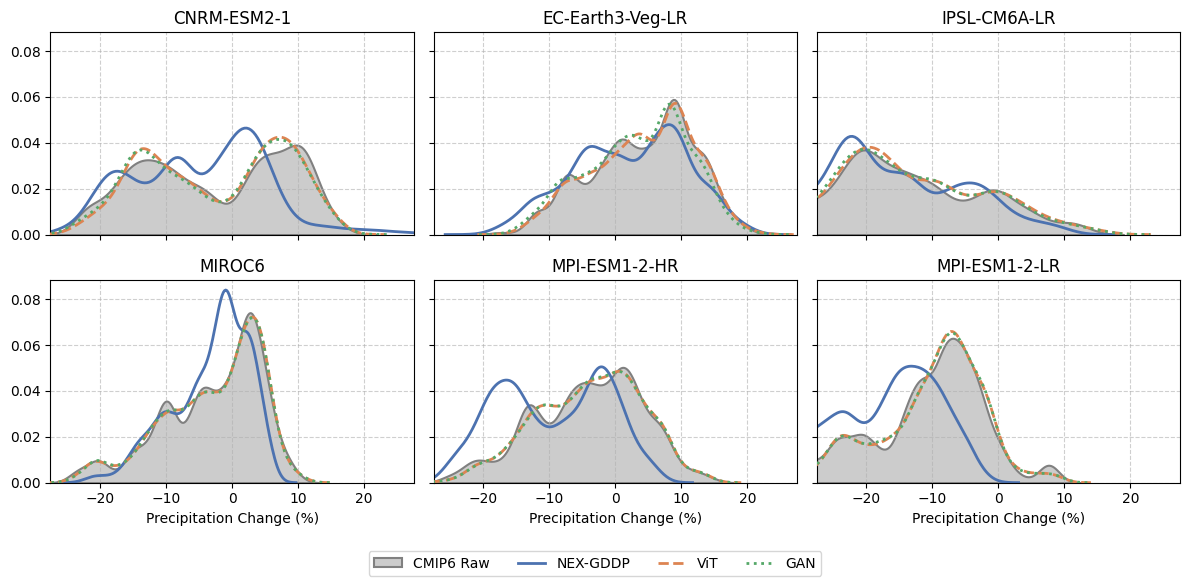

In [24]:

# --- PDF Plotting Section ---
if not valid_model_configs_for_diff_maps:
    print("No models have sufficient data for plotting difference PDFs.")
elif global_min_diff == np.inf or global_max_diff == -np.inf:
    print("Could not determine a valid global precipitation difference range. Exiting PDF plotting.")
else:
    print("Data for difference PDFs prepared. Now plotting...")

    num_models_to_plot_pdfs = len(valid_model_configs_for_diff_maps)

    if num_models_to_plot_pdfs > 0:
        # --- Define plot layout: 3 columns ---
        ncols_pdf = 3
        # Calculate number of rows needed based on models and columns
        nrows_pdf = (num_models_to_plot_pdfs + ncols_pdf - 1) // ncols_pdf

        fig_pdfs, axes_pdfs_flat = plt.subplots(
            nrows=nrows_pdf,
            ncols=ncols_pdf,
            figsize=(4 * ncols_pdf, 3 * nrows_pdf), # Adjust width per col, height per row
            sharex=True,  # All PDF plots will share the same x-axis (precipitation Change)
            sharey=True,  # Optionally share y-axis for consistent density scaling
            squeeze=False
        )
        axes_pdfs_flat = axes_pdfs_flat.flatten() # Flatten for easy iteration


        # --- Define a color palette and line styles ---
        # First dataset (e.g., 'CMIP6 Raw') special handling
        first_dataset_name = dataset_order_for_maps[0]
        other_dataset_names = dataset_order_for_maps[1:]

        # Colors for 'other' datasets (lines)
        # Using a qualitative palette, skipping gray-like colors if possible
        line_colors = sns.color_palette("deep", n_colors=len(other_dataset_names))
        
        # Line styles for 'other' datasets to further differentiate
        line_styles = ['-', '--', ':', '-.'] * (len(other_dataset_names) // 4 + 1)


        for i, config_pdf in enumerate(valid_model_configs_for_diff_maps):
            model_name = config_pdf["name"]
            ax = axes_pdfs_flat[i]  # Current axis for this model's PDF plot

            has_data_for_this_subplot = False

            # 1. Plot the first dataset (e.g., 'CMIP6 Raw') with gray shading
            current_diff_map_first = all_diff_mean_maps.get(model_name, {}).get(first_dataset_name)
            if current_diff_map_first is not None and not current_diff_map_first.isnull().all():
                data_values_first = current_diff_map_first.data.flatten()
                data_values_first = data_values_first[~np.isnan(data_values_first)]
                if data_values_first.size > 1:
                    sns.kdeplot(
                        data_values_first,
                        ax=ax,
                        label=first_dataset_name,
                        color='gray',    # Gray color
                        fill=True,       # Fill under the KDE curve
                        alpha=0.4,       # Transparency for the fill
                        linewidth=1.5,   # Slightly thicker line for the filled area
                        zorder=1         # Ensure it's plotted behind other lines
                    )
                    has_data_for_this_subplot = True
                else:
                    print(f"Warning: Not enough data for KDE for {model_name} - {first_dataset_name} (found {data_values_first.size}).")


            # 2. Plot other datasets as lines
            for k, ds_name in enumerate(other_dataset_names):
                current_diff_map = all_diff_mean_maps.get(model_name, {}).get(ds_name)
                if current_diff_map is not None and not current_diff_map.isnull().all():
                    data_values = current_diff_map.data.flatten()
                    data_values = data_values[~np.isnan(data_values)]

                    if data_values.size > 1:
                        sns.kdeplot(
                            data_values,
                            ax=ax,
                            label=ds_name,
                            color=line_colors[k % len(line_colors)], # Cycle through colors
                            linestyle=line_styles[k % len(line_styles)], # Cycle through linestyles
                            linewidth=2,    # Make lines prominent
                            fill=False,     # No fill for these
                            zorder=2 + k    # Ensure lines are on top of fill and each other
                        )
                        has_data_for_this_subplot = True
                    else:
                        print(f"Warning: Not enough data for KDE for {model_name} - {ds_name} (found {data_values.size}).")
                else:
                    print(f"Info: No diff map data for {model_name} - {ds_name} to plot PDF.")

            ax.set_title(model_name, fontsize=12) # Slightly smaller title for more plots

            if i % ncols_pdf == 0: # Only show Y-label on the first column of plots
                ax.set_ylabel("", fontsize=10)
            else:
                ax.set_ylabel("") # Clear y-label for other columns

            if i >= num_models_to_plot_pdfs - ncols_pdf : # Only show X-label on the bottom row of plots
                 ax.set_xlabel("Precipitation Change (%)", fontsize=10)
            else:
                ax.set_xlabel("") # Clear x-label for other rows


            ax.grid(True, linestyle='--', alpha=0.6)

            # Common x-axis limits
            x_padding = (plot_vmax_diff - plot_vmin_diff) * 0.05
            ax.set_xlim(plot_vmin_diff - x_padding, plot_vmax_diff + x_padding)
            
            # Y-axis limits (optional, if sharey=True is used and you want to fix them)
            # You might need to run once to see typical density ranges, or calculate global max density
            # ax.set_ylim(0, some_max_density_value)


        # --- Create a single legend for the entire figure ---
        # Get handles and labels from one of the axes that has plotted data
        # It's a bit tricky if some plots are empty. We'll try from the first.
        handles, labels = [], []
        for ax_check in axes_pdfs_flat:
            if ax_check.get_legend_handles_labels()[0]: # if it has any handles
                handles, labels = ax_check.get_legend_handles_labels()
                # Remove individual legends from subplots now that we'll have a common one
                if ax_check.get_legend() is not None:
                    ax_check.get_legend().remove()
                break # Found handles, no need to check further

        if handles: # If we got any handles
            # Manually order handles and labels to match dataset_order_for_maps
            ordered_handles_labels = []
            for ds_name_ordered in dataset_order_for_maps:
                try:
                    idx = labels.index(ds_name_ordered)
                    ordered_handles_labels.append((handles[idx], labels[idx]))
                except ValueError:
                    pass # This dataset might not have been plotted in the first subplot
            
            if ordered_handles_labels:
                final_handles, final_labels = zip(*ordered_handles_labels)
                fig_pdfs.legend(
                    final_handles, final_labels,
                    loc='lower center', # Position the legend
                    bbox_to_anchor=(0.5, -0.02 if nrows_pdf > 1 else 0.01), # Adjust based on rows
                    ncol=len(dataset_order_for_maps), # Number of columns in legend
                    fontsize=10,
                    title_fontsize=11
                )
            else:
                 print("Warning: Could not create a common legend; no plottable data found for initial legend creation.")
        else:
            print("Warning: Could not create a common legend; no handles/labels found.")


        # --- Hide unused axes if num_models < nrows * ncols ---
        for j in range(num_models_to_plot_pdfs, nrows_pdf * ncols_pdf):
            fig_pdfs.delaxes(axes_pdfs_flat[j])

        # Adjust layout
        fig_pdfs.tight_layout(rect=[0, 0.05, 1, 0.96]) # rect=[left, bottom, right, top]

        plt.show()

    else: # num_models_to_plot_pdfs == 0
        print("No models available to plot PDFs after filtering.")